# Physical-Informed model of well

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.model_selection import train_test_split

import os
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data import TensorDataset
import torchvision.transforms.functional as TF

from collections import OrderedDict

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Pre-processing dataset

In [4]:
path = 'ML/models/'

In [5]:
perm = np.load('perms_clear.npy')
pressure = np.load('pressures_clear.npy')

In [6]:
perm.shape

(1317, 64, 64)

In [7]:
pressure.shape

(1317, 21, 64, 64)

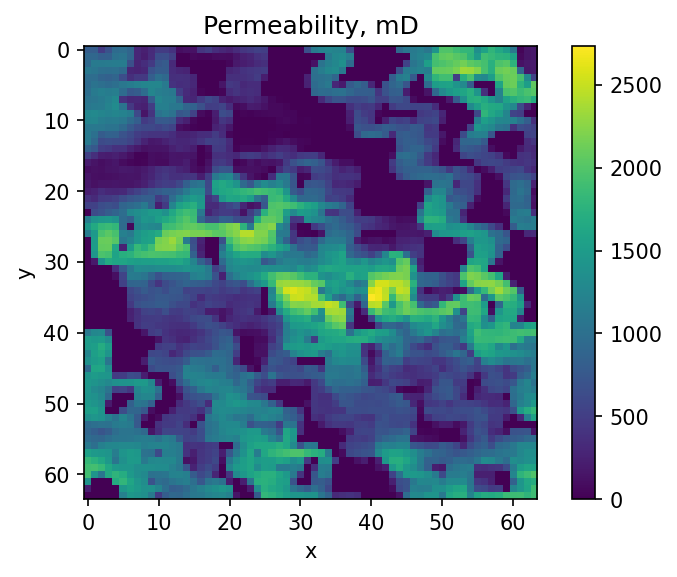

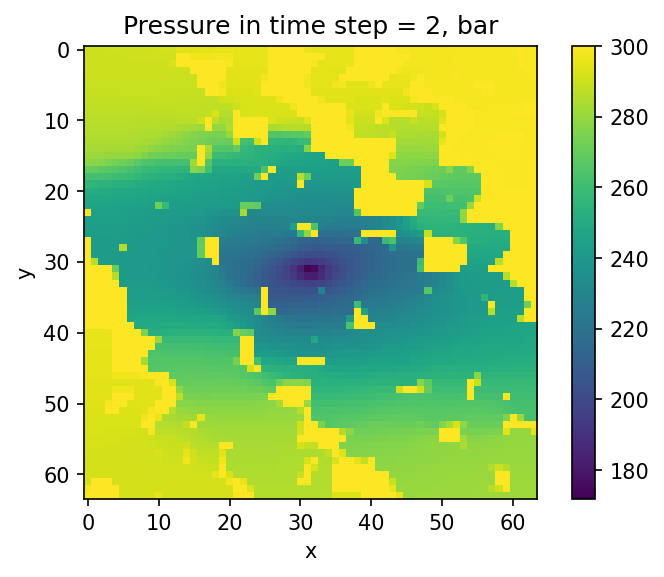

In [8]:
plt.figure(dpi=150)
plt.imshow(perm[1])
plt.subplots_adjust()
plt.colorbar()
plt.title('Permeability, mD')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

plt.figure(dpi=150)
i = 2
plt.imshow(pressure[1][i])
plt.subplots_adjust()
plt.colorbar()
plt.title(f'Pressure in time step = {i}, bar')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## Dataset

In [9]:
x, y = [], []
for i in tqdm(range(len(pressure))):
    for j in range(len(pressure[i])):
        inp = np.stack((perm[i], np.ones((64,64))*j))
        x.append(inp)
        out = np.reshape(pressure[i][j],(1,64,64))
        y.append(out)
x = np.stack(tuple(x))
y = np.stack(tuple(y))

100%|██████████████████████████████████████| 1317/1317 [00:01<00:00, 757.46it/s]


In [10]:
print(f'x shape {x.shape}\ny shape {y.shape}')

x shape (27657, 2, 64, 64)
y shape (27657, 1, 64, 64)


In [11]:
# x_train, x_val_test, y_train, y_val_test = train_test_split(x, y, test_size=0.2, random_state=42, shuffle=False)
# x_val, x_test, y_val, y_test = train_test_split(x_val_test, y_val_test, test_size=0.5, random_state=42, shuffle=False)
total_size = x.shape[0]
bs = 21
total_batches = total_size / bs
train_test_split_values = np.floor(np.array([0.8, 0.1, 0.1]) * total_batches) * bs
ths = train_test_split_values.astype(int)
print(ths)

x_train = x[0:ths[0]]
y_train = y[0:ths[0]]
x_val = x[ths[0]:ths[0]+ths[1]]
y_val = y[ths[0]:ths[0]+ths[1]]
x_test = x[ths[0]+ths[1]:ths[0]+ths[1]+ths[2]]
y_test = y[ths[0]+ths[1]:ths[0]+ths[1]+ths[2]]


print(f'The train size {len(x_train)}',
      f'\nThe val size {len(x_val)}',
     f'\nThe test size {len(x_test)}')

x_train = torch.from_numpy(x_train).to(device)
x_val = torch.from_numpy(x_val).to(device)
x_test = torch.from_numpy(x_test).to(device)
y_train = torch.from_numpy(y_train).to(device)
y_val = torch.from_numpy(y_val).to(device)
y_test = torch.from_numpy(y_test).to(device)

[22113  2751  2751]
The train size 22113 
The val size 2751 
The test size 2751


In [12]:
!nvidia-smi

Tue Mar 28 20:53:19 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:02:00.0 Off |                  N/A |
| 27%   41C    P2    68W / 250W |   3111MiB / 11176MiB |     64%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:03:00.0 Off |                  N/A |
| 21%   

In [13]:
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)
test_dataset = TensorDataset(x_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=bs, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=len(x_test), shuffle=False, num_workers=0)

# Model architecture

In [14]:
class UNet(nn.Module):

    def __init__(self, in_channels=3, out_channels=1, init_features=32):
        super(UNet, self).__init__()

        features = init_features
        self.encoder1 = UNet._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = UNet._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = UNet._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = UNet._block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = UNet._block(features * 8, features * 16, name="bottleneck")

        self.upconv4 = nn.ConvTranspose2d(
            features * 16, features * 8, kernel_size=2, stride=2
        )
        self.decoder4 = UNet._block((features * 8) * 2, features * 8, name="dec4")
        self.upconv3 = nn.ConvTranspose2d(
            features * 8, features * 4, kernel_size=2, stride=2
        )
        self.decoder3 = UNet._block((features * 4) * 2, features * 4, name="dec3")
        self.upconv2 = nn.ConvTranspose2d(
            features * 4, features * 2, kernel_size=2, stride=2
        )
        self.decoder2 = UNet._block((features * 2) * 2, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose2d(
            features * 2, features, kernel_size=2, stride=2
        )
        self.decoder1 = UNet._block(features * 2, features, name="dec1")

        self.conv = nn.Conv2d(
            in_channels=features, out_channels=out_channels, kernel_size=1
        )

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
#         return torch.sigmoid(self.conv(dec1))
        return self.conv(dec1)


    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            OrderedDict(
                [
                    (
                        name + "conv1",
                        nn.Conv2d(
                            in_channels=in_channels,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm1", nn.BatchNorm2d(num_features=features)),
                    (name + "relu1", nn.ReLU(inplace=True)),
                    (
                        name + "conv2",
                        nn.Conv2d(
                            in_channels=features,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm2", nn.BatchNorm2d(num_features=features)),
                    (name + "relu2", nn.ReLU(inplace=True)),
                ]
            )
        )

# Adding losses

In [15]:
def loss_data(h_real, h_pred):
    return torch.mean(torch.square(h_real - h_pred))

In [16]:
def torch_gradient(input, h, dx=200, dy=100):

    dhx, dhy = torch.gradient(h, spacing=(dx, dy), dim=(2, 3))
    Kdhx = input[:, 0, :, :].view(-1, 1, 64, 64) * dhx
    Kdhy = input[:, 0, :, :].view(-1, 1, 64, 64) * dhy
    
    dKdhx = torch.gradient(Kdhx, spacing=dx, dim=2)[0]
    dKdhy = torch.gradient(Kdhy, spacing=dy, dim=3)[0]

    return dKdhx + dKdhy

In [17]:
def hdt(h, S=5, dt=365*86400):
    partial_t = S * torch.gradient(h, spacing=dt, dim=0)[0]
    return partial_t

In [20]:
def loss_pde(input, h_pred, dx=200, dy=100, S=1e-4, dt=365*86400):
    nabla_K_nabla_h = torch_gradient(input, h_pred, dx=dx, dy=dy)
    # Sdhdt = hdt(h_pred, S=S, dt=dt)
    return torch.mean(torch.square(nabla_K_nabla_h))

## Model training

# Data

In [22]:
model = UNet(in_channels=2, out_channels=1, init_features=64)

logging = []
mltplr = 1

def train(model, opt, criterion, n_epochs, scheduler):

    min_val_loss = np.inf
    for epoch in tqdm(range(n_epochs)):
        model.train()
        
        train_batch_loss = []
        train_batch_data_loss = []
        train_batch_pde_loss = []
        for batch in train_loader:
            sample, target = batch
            sample, target = sample.to(device, torch.float), target.to(device, torch.float) 
            pred = model(sample)

            data_loss = loss_data(target, pred)
            pde_loss = mltplr*loss_pde(sample, pred)
            loss = data_loss # + pde_loss
            
            opt.zero_grad()
            loss.backward()
            opt.step()
            train_batch_loss.append(loss.item())
            train_batch_data_loss.append(data_loss.item())
            train_batch_pde_loss.append(pde_loss.item())

        train_loss = np.mean(train_batch_loss)
        train_data_loss = np.mean(train_batch_data_loss)
        train_pde_loss = np.mean(train_batch_pde_loss)
    
        model.eval()
        
        val_batch_loss = []
        val_batch_data_loss = []
        val_batch_pde_loss = []
        for batch in val_loader:
            sample, target = batch
            sample, target = sample.to(device, torch.float), target.to(device, torch.float)
            pred = model(sample)

            data_loss = loss_data(target, pred)
            pde_loss = mltplr*loss_pde(sample, pred)
            loss = data_loss

            val_batch_loss.append(loss.item())
            val_batch_data_loss.append(data_loss.item())
            val_batch_pde_loss.append(pde_loss.item())
            
        val_loss = np.mean(val_batch_loss)
        val_data_loss = np.mean(val_batch_data_loss)
        val_pde_loss = np.mean(val_batch_pde_loss)

        scheduler.step(val_loss)
               
        logging.append(np.array([epoch, train_loss, train_data_loss, train_pde_loss, val_loss, val_data_loss, val_pde_loss]))
        if val_loss > min_val_loss:
            f+=1
            print(f'epoch: {epoch}, val loss did not decrease for {f} epoch(s)')
        else:
            print(f'epoch: {epoch}, val loss did decrease, saving model')
            f=0
            folder = path
            model_name_cur = f'PINN_non_steady_DATA_v2_current.pth'
            model_path = folder + model_name_cur
            torch.save(model, model_path)
            min_val_loss = val_loss
        
        if f>=10:
            break
        
        print(f'epoch: {epoch}, TRAIN_LOSS: [TOTAL: {round(train_loss, 1)} DATA: {round(train_data_loss, 1)}, PDE: {round(train_pde_loss, 1)}], \tVAL LOSS: [TOTAL: TOTAL: {round(val_loss, 1)} DATA: {round(val_data_loss, 1)}, PDE: {round(val_pde_loss, 1)}]')
        # wandb.log({'epoch': epoch, 'train_loss': train_loss, 'val_loss': val_loss})
        
        # если в течение 10 эпох ошибка на валидации не уменьшается, то прерываем обучение

'''
if torch.cuda.device_count() > 1:
    print("GPUs:", torch.cuda.device_count())
    model = nn.DataParallel(model, device_ids=[2, 3])
'''

model = UNet(in_channels=2, out_channels=1, init_features=64)
model.to(device)
lr = 3e-4
opt = torch.optim.Adam(model.parameters(), lr)
n_epochs = 1000
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt)
criterion = nn.MSELoss()

train(model, opt, criterion, n_epochs, scheduler=scheduler)

  0%|                                                  | 0/1000 [00:00<?, ?it/s]

epoch: 0, val loss did decrease, saving model


  0%|                                       | 1/1000 [01:05<18:10:47, 65.51s/it]

epoch: 0, TRAIN_LOSS: [TOTAL: 54364.7 DATA: 54364.7, PDE: 0.0], 	VAL LOSS: [TOTAL: TOTAL: 48311.4 DATA: 48311.4, PDE: 0.1]
epoch: 1, val loss did decrease, saving model


  0%|                                       | 2/1000 [02:10<18:09:09, 65.48s/it]

epoch: 1, TRAIN_LOSS: [TOTAL: 43154.7 DATA: 43154.7, PDE: 0.2], 	VAL LOSS: [TOTAL: TOTAL: 34375.7 DATA: 34375.7, PDE: 0.4]
epoch: 2, val loss did decrease, saving model


  0%|                                       | 3/1000 [03:16<18:08:24, 65.50s/it]

epoch: 2, TRAIN_LOSS: [TOTAL: 29284.1 DATA: 29284.1, PDE: 0.8], 	VAL LOSS: [TOTAL: TOTAL: 23195.0 DATA: 23195.0, PDE: 1.1]
epoch: 3, val loss did decrease, saving model


  0%|▏                                      | 4/1000 [04:22<18:07:57, 65.54s/it]

epoch: 3, TRAIN_LOSS: [TOTAL: 16851.1 DATA: 16851.1, PDE: 1.5], 	VAL LOSS: [TOTAL: TOTAL: 10211.8 DATA: 10211.8, PDE: 1.8]
epoch: 4, val loss did decrease, saving model


  0%|▏                                      | 5/1000 [05:27<18:06:48, 65.54s/it]

epoch: 4, TRAIN_LOSS: [TOTAL: 7947.6 DATA: 7947.6, PDE: 2.1], 	VAL LOSS: [TOTAL: TOTAL: 6167.7 DATA: 6167.7, PDE: 2.6]
epoch: 5, val loss did decrease, saving model


  1%|▏                                      | 6/1000 [06:33<18:05:48, 65.54s/it]

epoch: 5, TRAIN_LOSS: [TOTAL: 2964.4 DATA: 2964.4, PDE: 2.1], 	VAL LOSS: [TOTAL: TOTAL: 1768.2 DATA: 1768.2, PDE: 2.0]
epoch: 6, val loss did decrease, saving model


  1%|▎                                      | 7/1000 [07:38<18:04:45, 65.54s/it]

epoch: 6, TRAIN_LOSS: [TOTAL: 965.1 DATA: 965.1, PDE: 1.9], 	VAL LOSS: [TOTAL: TOTAL: 642.4 DATA: 642.4, PDE: 1.6]
epoch: 7, val loss did decrease, saving model


  1%|▎                                      | 8/1000 [08:44<18:03:25, 65.53s/it]

epoch: 7, TRAIN_LOSS: [TOTAL: 367.6 DATA: 367.6, PDE: 1.6], 	VAL LOSS: [TOTAL: TOTAL: 558.3 DATA: 558.3, PDE: 1.6]
epoch: 8, val loss did decrease, saving model


  1%|▎                                      | 9/1000 [09:49<18:02:49, 65.56s/it]

epoch: 8, TRAIN_LOSS: [TOTAL: 244.4 DATA: 244.4, PDE: 1.5], 	VAL LOSS: [TOTAL: TOTAL: 396.5 DATA: 396.5, PDE: 1.3]


  1%|▍                                     | 10/1000 [10:54<17:59:27, 65.42s/it]

epoch: 9, val loss did not decrease for 1 epoch(s)
epoch: 9, TRAIN_LOSS: [TOTAL: 213.4 DATA: 213.4, PDE: 1.5], 	VAL LOSS: [TOTAL: TOTAL: 414.7 DATA: 414.7, PDE: 1.5]
epoch: 10, val loss did decrease, saving model


  1%|▍                                     | 11/1000 [12:00<18:00:19, 65.54s/it]

epoch: 10, TRAIN_LOSS: [TOTAL: 200.6 DATA: 200.6, PDE: 1.5], 	VAL LOSS: [TOTAL: TOTAL: 378.3 DATA: 378.3, PDE: 1.7]
epoch: 11, val loss did decrease, saving model


  1%|▍                                     | 12/1000 [13:06<17:59:01, 65.53s/it]

epoch: 11, TRAIN_LOSS: [TOTAL: 220.0 DATA: 220.0, PDE: 1.5], 	VAL LOSS: [TOTAL: TOTAL: 368.9 DATA: 368.9, PDE: 1.6]
epoch: 12, val loss did decrease, saving model


  1%|▍                                     | 13/1000 [14:11<17:57:34, 65.51s/it]

epoch: 12, TRAIN_LOSS: [TOTAL: 170.3 DATA: 170.3, PDE: 1.5], 	VAL LOSS: [TOTAL: TOTAL: 362.6 DATA: 362.6, PDE: 1.6]


  1%|▌                                     | 14/1000 [15:16<17:54:23, 65.38s/it]

epoch: 13, val loss did not decrease for 1 epoch(s)
epoch: 13, TRAIN_LOSS: [TOTAL: 168.1 DATA: 168.1, PDE: 1.5], 	VAL LOSS: [TOTAL: TOTAL: 430.6 DATA: 430.6, PDE: 1.3]


  2%|▌                                     | 15/1000 [16:21<17:51:39, 65.28s/it]

epoch: 14, val loss did not decrease for 2 epoch(s)
epoch: 14, TRAIN_LOSS: [TOTAL: 152.3 DATA: 152.3, PDE: 1.5], 	VAL LOSS: [TOTAL: TOTAL: 396.3 DATA: 396.3, PDE: 1.6]


  2%|▌                                     | 16/1000 [17:26<17:48:57, 65.18s/it]

epoch: 15, val loss did not decrease for 3 epoch(s)
epoch: 15, TRAIN_LOSS: [TOTAL: 157.5 DATA: 157.5, PDE: 1.5], 	VAL LOSS: [TOTAL: TOTAL: 389.6 DATA: 389.6, PDE: 1.5]
epoch: 16, val loss did decrease, saving model


  2%|▋                                     | 17/1000 [18:32<17:49:36, 65.29s/it]

epoch: 16, TRAIN_LOSS: [TOTAL: 136.6 DATA: 136.6, PDE: 1.5], 	VAL LOSS: [TOTAL: TOTAL: 346.6 DATA: 346.6, PDE: 1.3]


  2%|▋                                     | 18/1000 [19:37<17:46:14, 65.15s/it]

epoch: 17, val loss did not decrease for 1 epoch(s)
epoch: 17, TRAIN_LOSS: [TOTAL: 129.7 DATA: 129.7, PDE: 1.5], 	VAL LOSS: [TOTAL: TOTAL: 356.5 DATA: 356.5, PDE: 1.6]


  2%|▋                                     | 19/1000 [20:42<17:43:38, 65.05s/it]

epoch: 18, val loss did not decrease for 2 epoch(s)
epoch: 18, TRAIN_LOSS: [TOTAL: 134.4 DATA: 134.4, PDE: 1.5], 	VAL LOSS: [TOTAL: TOTAL: 352.7 DATA: 352.7, PDE: 1.3]


  2%|▊                                     | 20/1000 [21:47<17:42:16, 65.04s/it]

epoch: 19, val loss did not decrease for 3 epoch(s)
epoch: 19, TRAIN_LOSS: [TOTAL: 134.9 DATA: 134.9, PDE: 1.5], 	VAL LOSS: [TOTAL: TOTAL: 395.4 DATA: 395.4, PDE: 1.8]


  2%|▊                                     | 21/1000 [22:51<17:40:23, 64.99s/it]

epoch: 20, val loss did not decrease for 4 epoch(s)
epoch: 20, TRAIN_LOSS: [TOTAL: 133.8 DATA: 133.8, PDE: 1.5], 	VAL LOSS: [TOTAL: TOTAL: 378.8 DATA: 378.8, PDE: 1.3]


  2%|▊                                     | 22/1000 [23:56<17:38:55, 64.97s/it]

epoch: 21, val loss did not decrease for 5 epoch(s)
epoch: 21, TRAIN_LOSS: [TOTAL: 120.1 DATA: 120.1, PDE: 1.5], 	VAL LOSS: [TOTAL: TOTAL: 358.7 DATA: 358.7, PDE: 1.3]


  2%|▊                                     | 23/1000 [25:01<17:38:05, 64.98s/it]

epoch: 22, val loss did not decrease for 6 epoch(s)
epoch: 22, TRAIN_LOSS: [TOTAL: 144.4 DATA: 144.4, PDE: 1.5], 	VAL LOSS: [TOTAL: TOTAL: 395.2 DATA: 395.2, PDE: 1.8]


  2%|▉                                     | 24/1000 [26:06<17:37:29, 65.01s/it]

epoch: 23, val loss did not decrease for 7 epoch(s)
epoch: 23, TRAIN_LOSS: [TOTAL: 120.4 DATA: 120.4, PDE: 1.5], 	VAL LOSS: [TOTAL: TOTAL: 349.2 DATA: 349.2, PDE: 1.5]
epoch: 24, val loss did decrease, saving model


  2%|▉                                     | 25/1000 [27:12<17:38:35, 65.14s/it]

epoch: 24, TRAIN_LOSS: [TOTAL: 112.9 DATA: 112.9, PDE: 1.5], 	VAL LOSS: [TOTAL: TOTAL: 342.5 DATA: 342.5, PDE: 1.5]


  3%|▉                                     | 26/1000 [28:17<17:35:59, 65.05s/it]

epoch: 25, val loss did not decrease for 1 epoch(s)
epoch: 25, TRAIN_LOSS: [TOTAL: 111.4 DATA: 111.4, PDE: 1.5], 	VAL LOSS: [TOTAL: TOTAL: 388.3 DATA: 388.3, PDE: 1.2]
epoch: 26, val loss did decrease, saving model


  3%|█                                     | 27/1000 [29:22<17:36:43, 65.16s/it]

epoch: 26, TRAIN_LOSS: [TOTAL: 106.5 DATA: 106.5, PDE: 1.5], 	VAL LOSS: [TOTAL: TOTAL: 333.6 DATA: 333.6, PDE: 1.5]


  3%|█                                     | 28/1000 [30:27<17:34:31, 65.09s/it]

epoch: 27, val loss did not decrease for 1 epoch(s)
epoch: 27, TRAIN_LOSS: [TOTAL: 108.7 DATA: 108.7, PDE: 1.5], 	VAL LOSS: [TOTAL: TOTAL: 348.3 DATA: 348.3, PDE: 1.3]


  3%|█                                     | 29/1000 [31:32<17:33:28, 65.10s/it]

epoch: 28, val loss did not decrease for 2 epoch(s)
epoch: 28, TRAIN_LOSS: [TOTAL: 105.6 DATA: 105.6, PDE: 1.5], 	VAL LOSS: [TOTAL: TOTAL: 343.0 DATA: 343.0, PDE: 1.6]


  3%|█▏                                    | 30/1000 [32:37<17:31:41, 65.05s/it]

epoch: 29, val loss did not decrease for 3 epoch(s)
epoch: 29, TRAIN_LOSS: [TOTAL: 105.2 DATA: 105.2, PDE: 1.5], 	VAL LOSS: [TOTAL: TOTAL: 339.9 DATA: 339.9, PDE: 1.4]


  3%|█▏                                    | 31/1000 [33:42<17:29:46, 65.00s/it]

epoch: 30, val loss did not decrease for 4 epoch(s)
epoch: 30, TRAIN_LOSS: [TOTAL: 102.1 DATA: 102.1, PDE: 1.5], 	VAL LOSS: [TOTAL: TOTAL: 386.0 DATA: 386.0, PDE: 1.2]


  3%|█▏                                    | 32/1000 [34:47<17:28:09, 64.97s/it]

epoch: 31, val loss did not decrease for 5 epoch(s)
epoch: 31, TRAIN_LOSS: [TOTAL: 92.0 DATA: 92.0, PDE: 1.5], 	VAL LOSS: [TOTAL: TOTAL: 365.2 DATA: 365.2, PDE: 1.3]


  3%|█▎                                    | 33/1000 [35:52<17:27:35, 65.00s/it]

epoch: 32, val loss did not decrease for 6 epoch(s)
epoch: 32, TRAIN_LOSS: [TOTAL: 100.4 DATA: 100.4, PDE: 1.5], 	VAL LOSS: [TOTAL: TOTAL: 451.5 DATA: 451.5, PDE: 1.1]


  3%|█▎                                    | 34/1000 [36:57<17:26:02, 64.97s/it]

epoch: 33, val loss did not decrease for 7 epoch(s)
epoch: 33, TRAIN_LOSS: [TOTAL: 93.7 DATA: 93.7, PDE: 1.5], 	VAL LOSS: [TOTAL: TOTAL: 346.4 DATA: 346.4, PDE: 1.3]
epoch: 34, val loss did decrease, saving model


  4%|█▎                                    | 35/1000 [38:02<17:27:12, 65.11s/it]

epoch: 34, TRAIN_LOSS: [TOTAL: 105.9 DATA: 105.9, PDE: 1.5], 	VAL LOSS: [TOTAL: TOTAL: 327.4 DATA: 327.4, PDE: 1.5]


  4%|█▎                                    | 36/1000 [39:07<17:24:54, 65.04s/it]

epoch: 35, val loss did not decrease for 1 epoch(s)
epoch: 35, TRAIN_LOSS: [TOTAL: 92.4 DATA: 92.4, PDE: 1.5], 	VAL LOSS: [TOTAL: TOTAL: 356.3 DATA: 356.3, PDE: 1.5]


  4%|█▍                                    | 37/1000 [40:12<17:23:50, 65.04s/it]

epoch: 36, val loss did not decrease for 2 epoch(s)
epoch: 36, TRAIN_LOSS: [TOTAL: 93.3 DATA: 93.3, PDE: 1.5], 	VAL LOSS: [TOTAL: TOTAL: 350.4 DATA: 350.4, PDE: 1.5]


  4%|█▍                                    | 38/1000 [41:17<17:22:36, 65.03s/it]

epoch: 37, val loss did not decrease for 3 epoch(s)
epoch: 37, TRAIN_LOSS: [TOTAL: 88.5 DATA: 88.5, PDE: 1.5], 	VAL LOSS: [TOTAL: TOTAL: 435.1 DATA: 435.1, PDE: 1.3]


  4%|█▍                                    | 39/1000 [42:22<17:20:53, 64.99s/it]

epoch: 38, val loss did not decrease for 4 epoch(s)
epoch: 38, TRAIN_LOSS: [TOTAL: 83.6 DATA: 83.6, PDE: 1.5], 	VAL LOSS: [TOTAL: TOTAL: 474.6 DATA: 474.6, PDE: 1.2]


  4%|█▌                                    | 40/1000 [43:27<17:19:28, 64.97s/it]

epoch: 39, val loss did not decrease for 5 epoch(s)
epoch: 39, TRAIN_LOSS: [TOTAL: 85.6 DATA: 85.6, PDE: 1.5], 	VAL LOSS: [TOTAL: TOTAL: 357.5 DATA: 357.5, PDE: 1.4]


  4%|█▌                                    | 41/1000 [44:32<17:18:27, 64.97s/it]

epoch: 40, val loss did not decrease for 6 epoch(s)
epoch: 40, TRAIN_LOSS: [TOTAL: 86.2 DATA: 86.2, PDE: 1.5], 	VAL LOSS: [TOTAL: TOTAL: 362.4 DATA: 362.4, PDE: 1.3]


  4%|█▌                                    | 42/1000 [45:37<17:16:49, 64.94s/it]

epoch: 41, val loss did not decrease for 7 epoch(s)
epoch: 41, TRAIN_LOSS: [TOTAL: 85.7 DATA: 85.7, PDE: 1.5], 	VAL LOSS: [TOTAL: TOTAL: 434.4 DATA: 434.4, PDE: 1.6]


  4%|█▋                                    | 43/1000 [46:42<17:15:26, 64.92s/it]

epoch: 42, val loss did not decrease for 8 epoch(s)
epoch: 42, TRAIN_LOSS: [TOTAL: 82.9 DATA: 82.9, PDE: 1.5], 	VAL LOSS: [TOTAL: TOTAL: 349.5 DATA: 349.5, PDE: 1.3]


  4%|█▋                                    | 44/1000 [47:47<17:14:13, 64.91s/it]

epoch: 43, val loss did not decrease for 9 epoch(s)
epoch: 43, TRAIN_LOSS: [TOTAL: 86.2 DATA: 86.2, PDE: 1.5], 	VAL LOSS: [TOTAL: TOTAL: 351.7 DATA: 351.7, PDE: 1.4]


  4%|█▋                                    | 44/1000 [48:51<17:41:43, 66.64s/it]

epoch: 44, val loss did not decrease for 10 epoch(s)


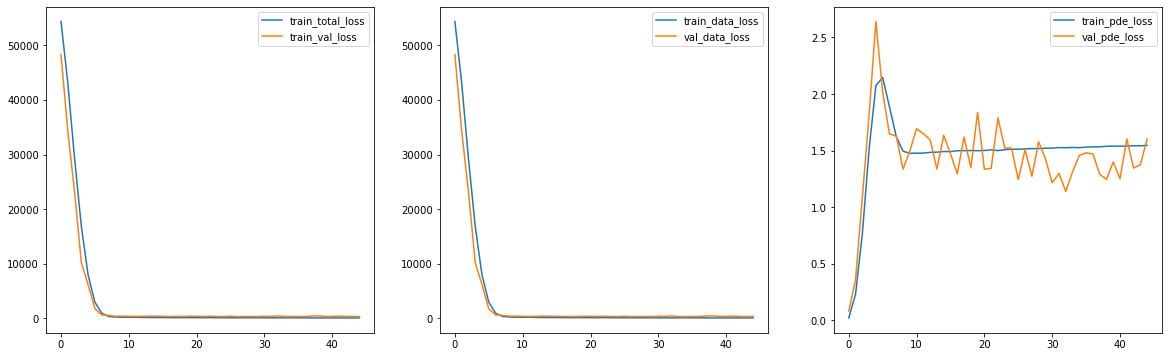

In [23]:
logging = np.array(logging)
np.save('logging_DATA_v2.npy',logging)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
ax1.plot(logging[:,0], logging[:,1], label='train_total_loss')
ax1.plot(logging[:,0], logging[:,4], label='train_val_loss')
ax1.legend()

ax2.plot(logging[:,0], logging[:,2], label='train_data_loss')
ax2.plot(logging[:,0], logging[:,5], label='val_data_loss')
ax2.legend()

ax3.plot(logging[:,0], logging[:,3], label='train_pde_loss')
ax3.plot(logging[:,0], logging[:,6], label='val_pde_loss')
ax3.legend()

plt.savefig('logging_DATA_v2.png', dpi=300)

## Results

In [31]:
folder = path
model_path_cur = folder+'PINN_non_steady_DATA_v2_current.pth'
model = torch.load(model_path_cur)
model.to(device)
model.eval()

UNet(
  (encoder1): Sequential(
    (enc1conv1): Conv2d(2, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu1): ReLU(inplace=True)
    (enc1conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu2): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (enc2conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc2relu1): ReLU(inplace=True)
    (enc2conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True

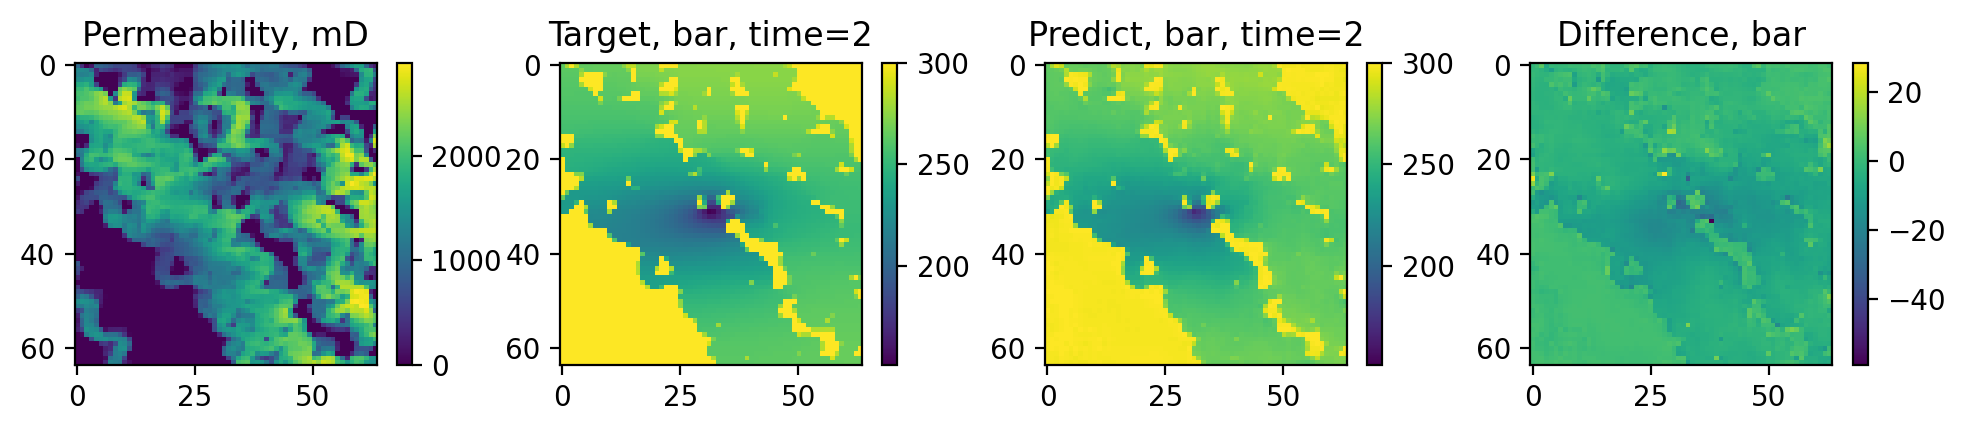

In [32]:
def one_prediction_with_x(idx):
    ex_x, ex_y = test_dataset[idx]
    ex_pred = model(ex_x.unsqueeze(0).to(device, dtype=torch.float)).cpu().detach().numpy()[0]
    target = ex_y.cpu().numpy()[0]
    pred = ex_pred[0]
    diff = ex_y.cpu().numpy()[0] - ex_pred[0]
    return target, pred, diff, ex_x.cpu().numpy()[0]

time = 2

fig, axes = plt.subplots(1, 4, figsize=(12,2), dpi=200)
target, pred, diff, k = one_prediction_with_x(time)
true = axes[0].imshow(k)
axes[0].set_title(f'Permeability, mD')
fig.colorbar(true, ax=axes[0])
true = axes[1].imshow(target, vmin = np.min(target), vmax = np.max(target))
axes[1].set_title(f'Target, bar, time={time}')
fig.colorbar(true, ax=axes[1])
true = axes[2].imshow(pred, vmin = np.min(target), vmax = np.max(target))
axes[2].set_title(f'Predict, bar, time={time}')
fig.colorbar(true, ax=axes[2])
true = axes[3].imshow(diff)
axes[3].set_title(f'Difference, bar')
fig.colorbar(true, ax=axes[3])
plt.savefig('examples_DATA_v2.png', dpi=300)
plt.show()

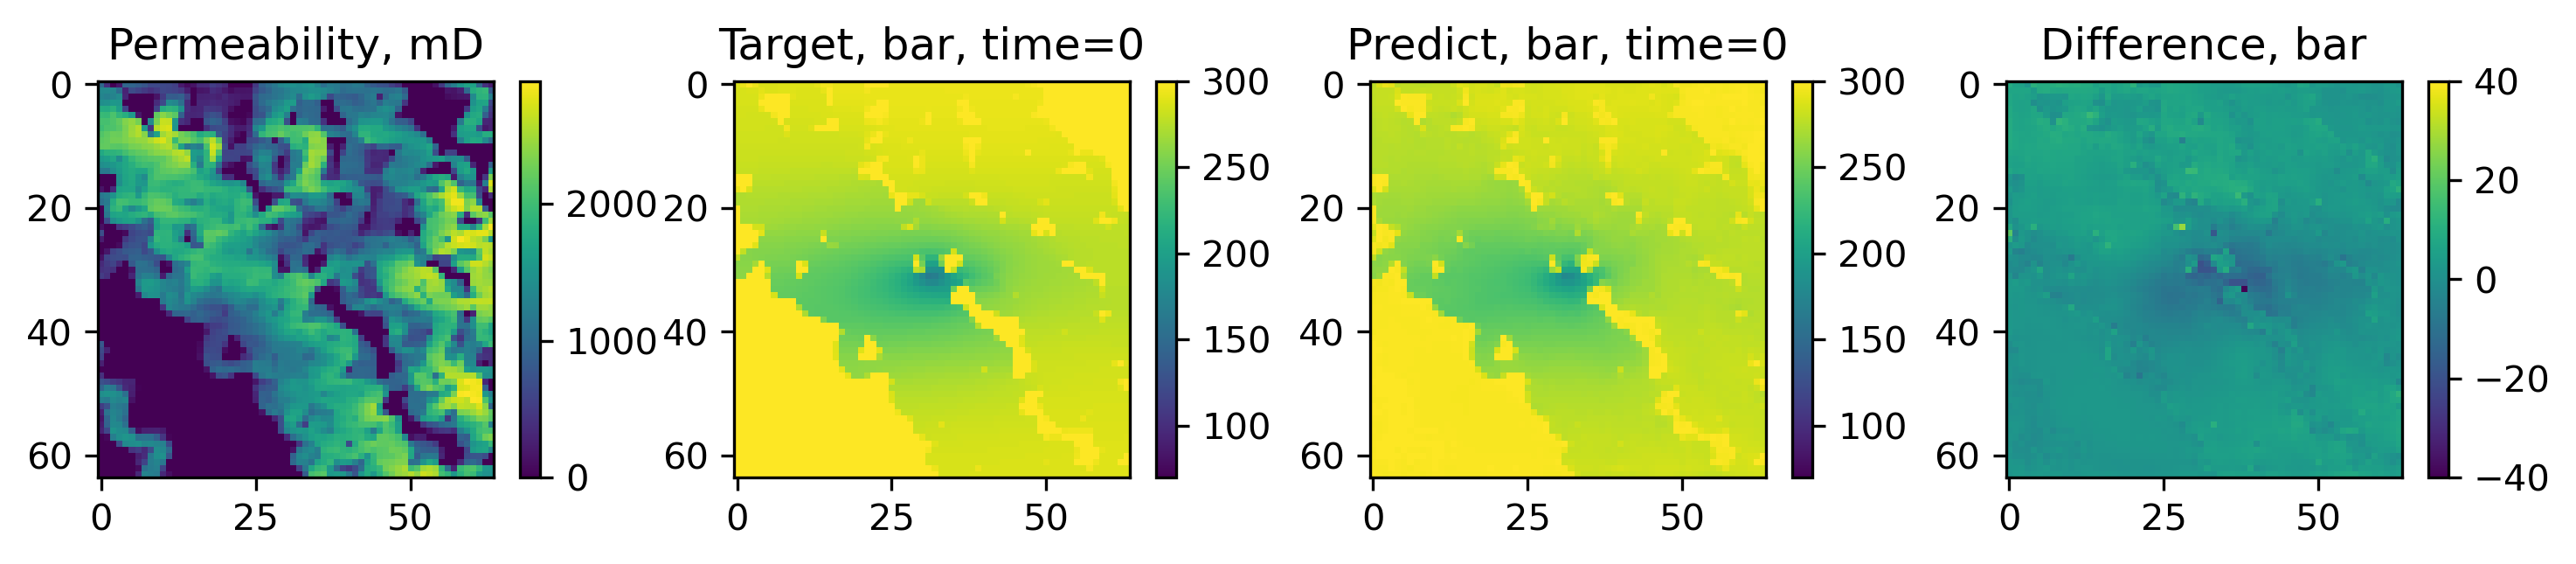

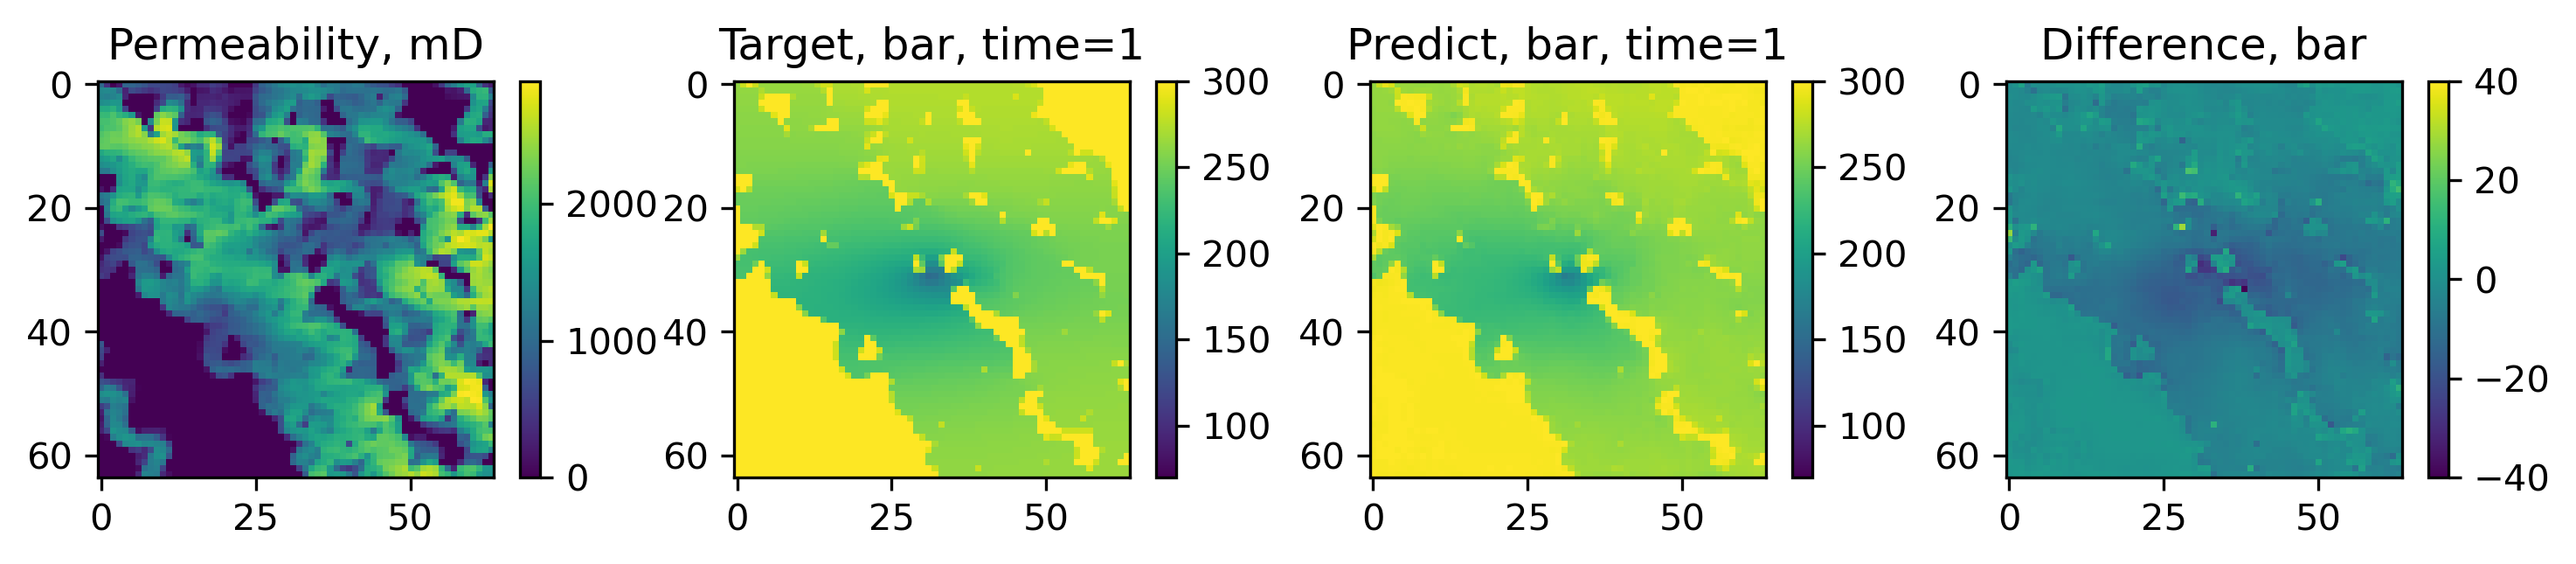

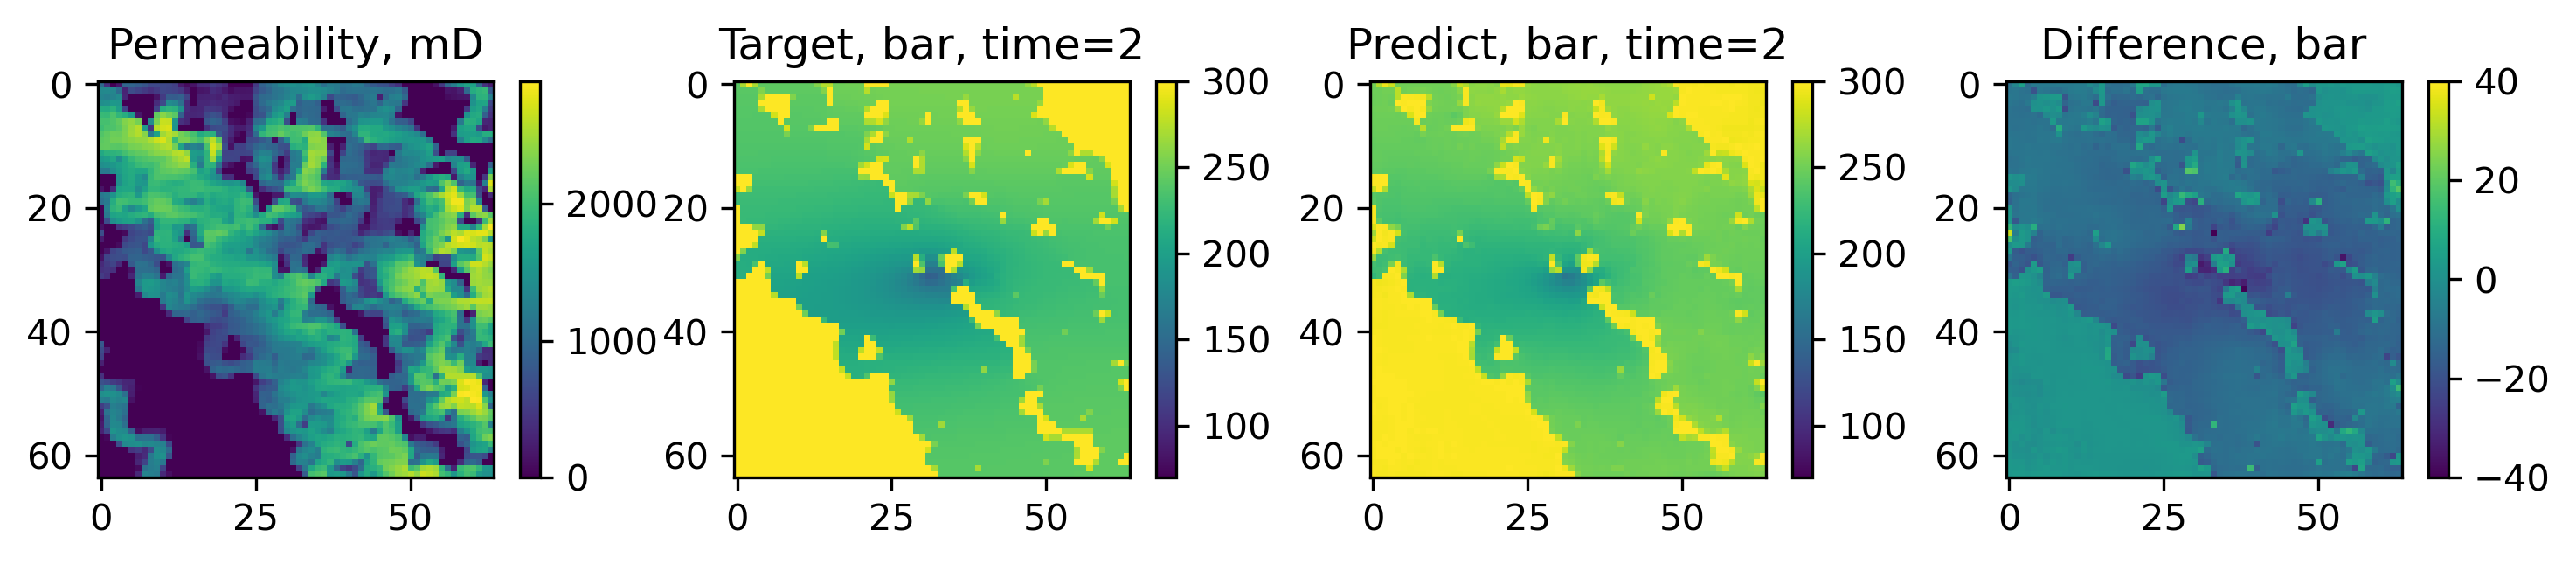

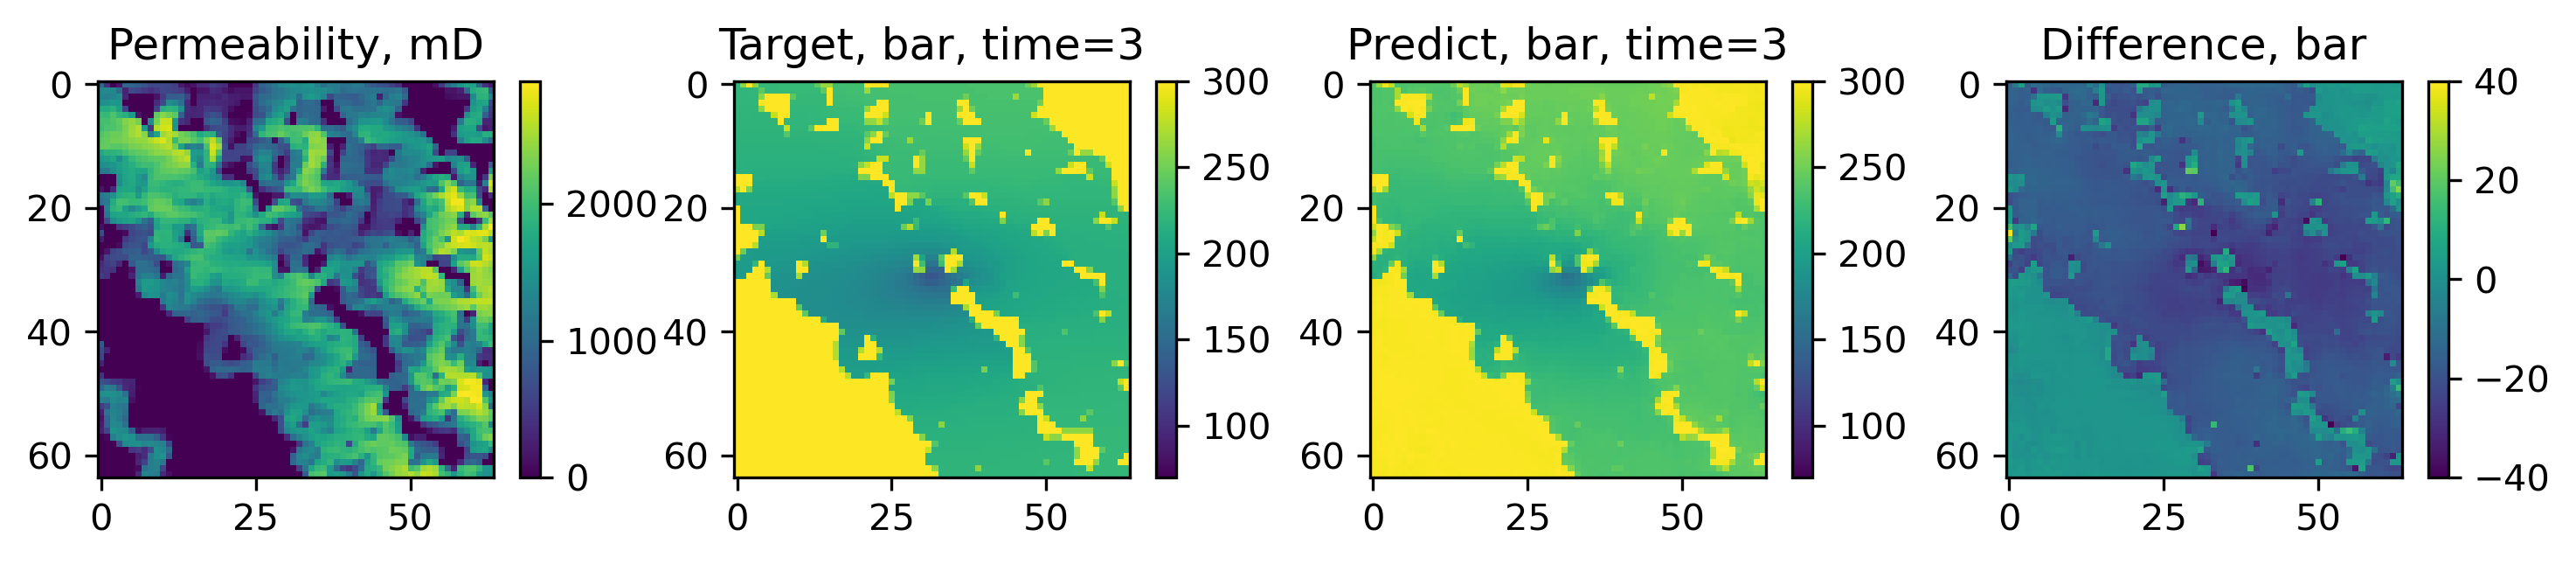

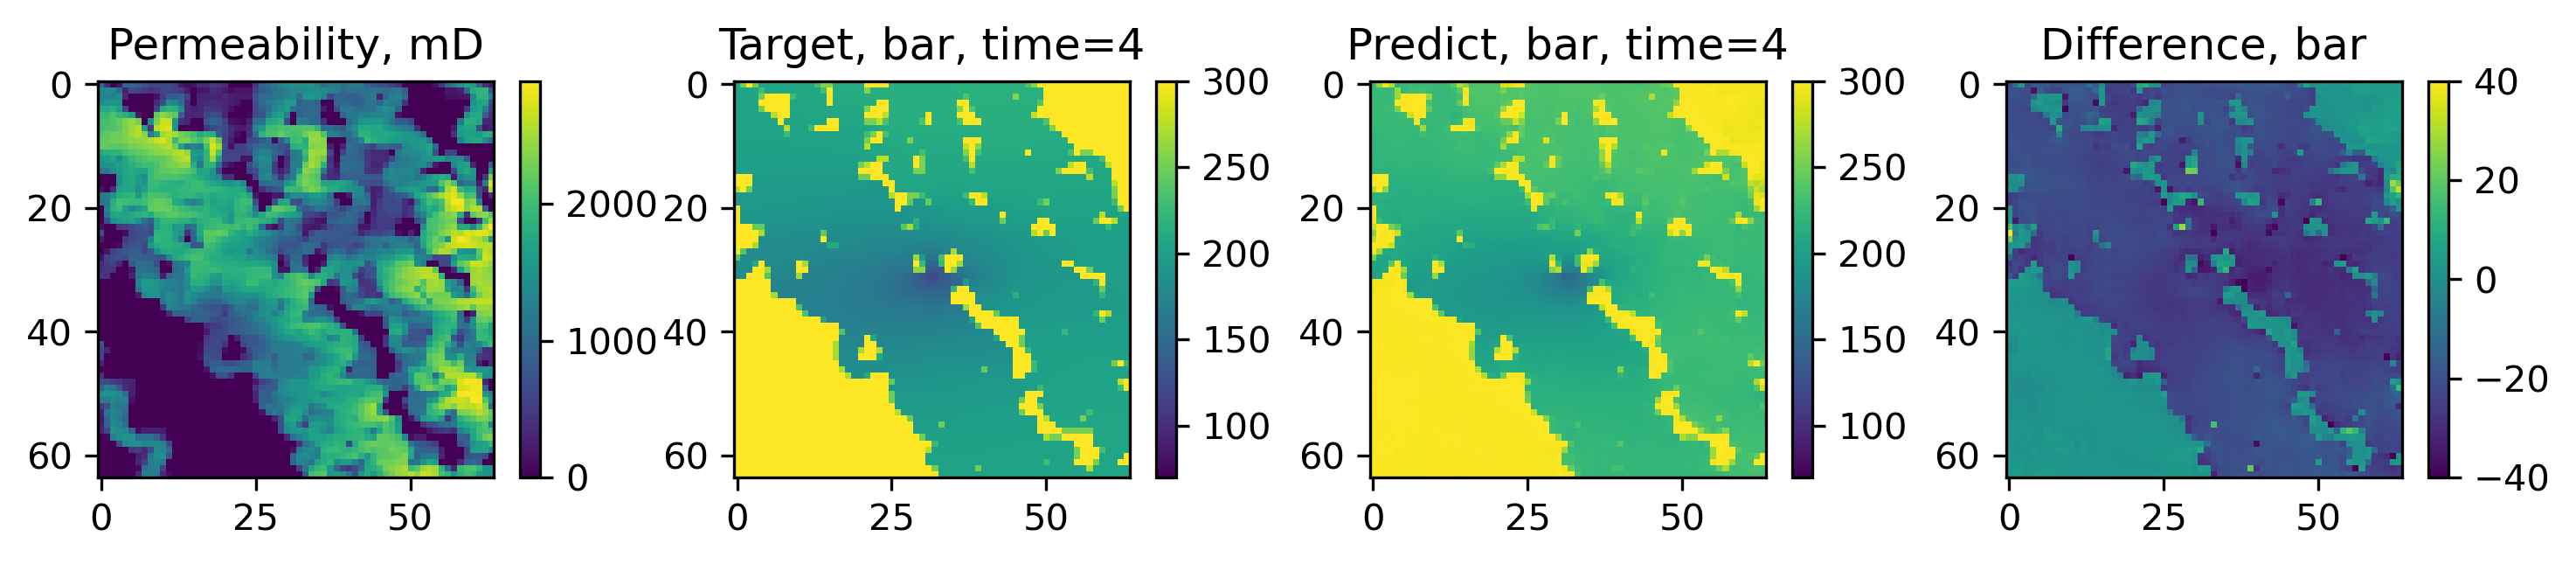

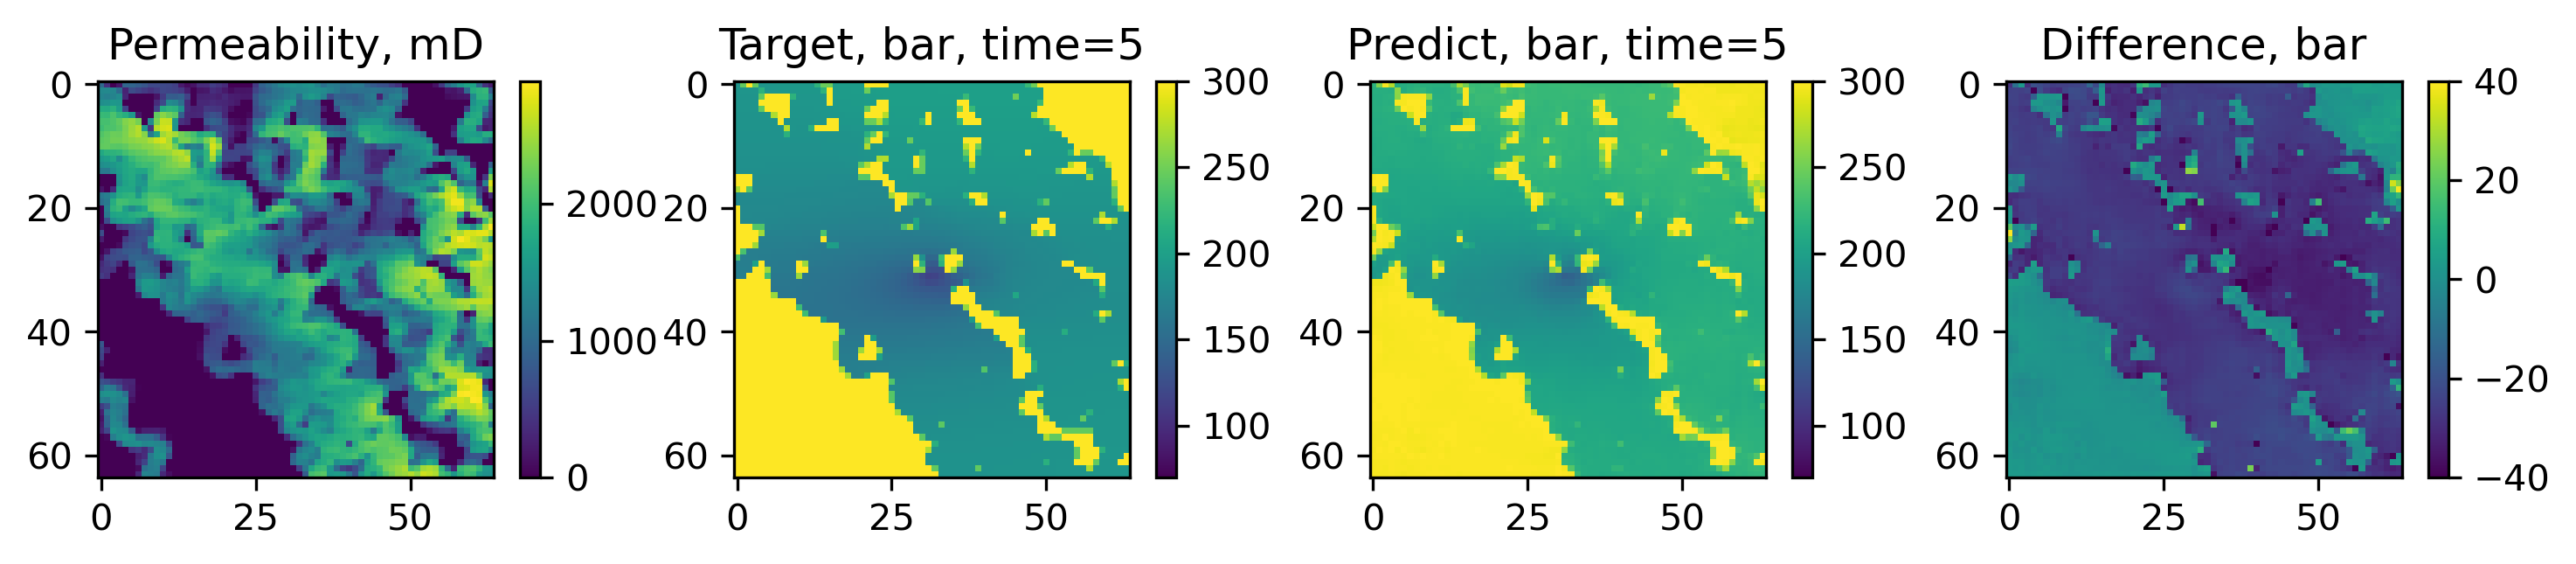

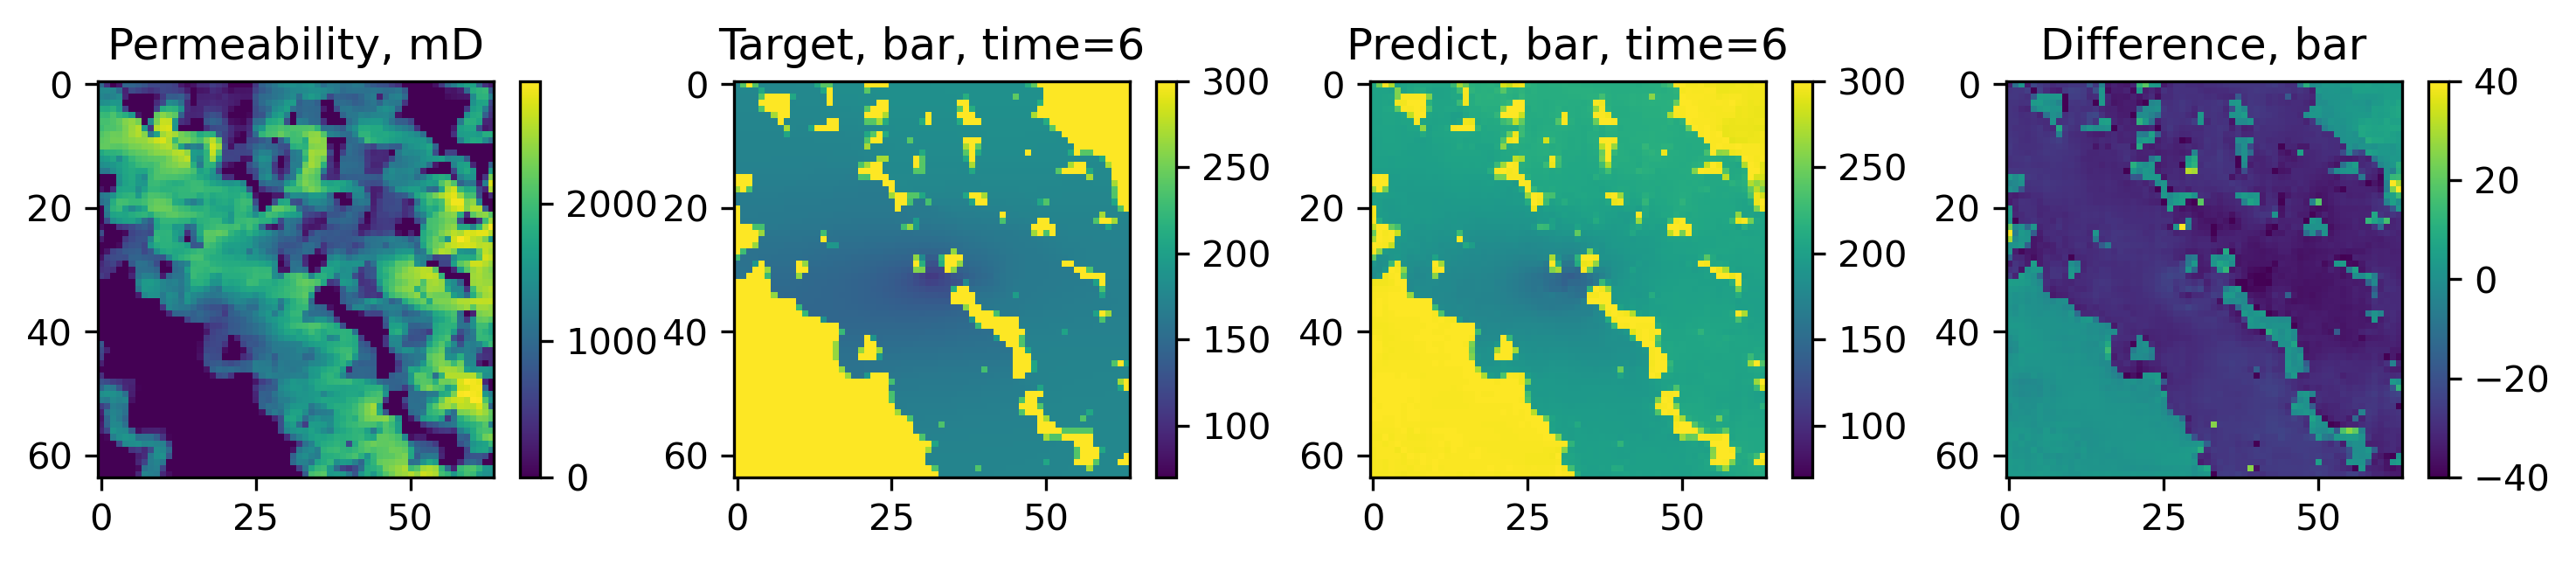

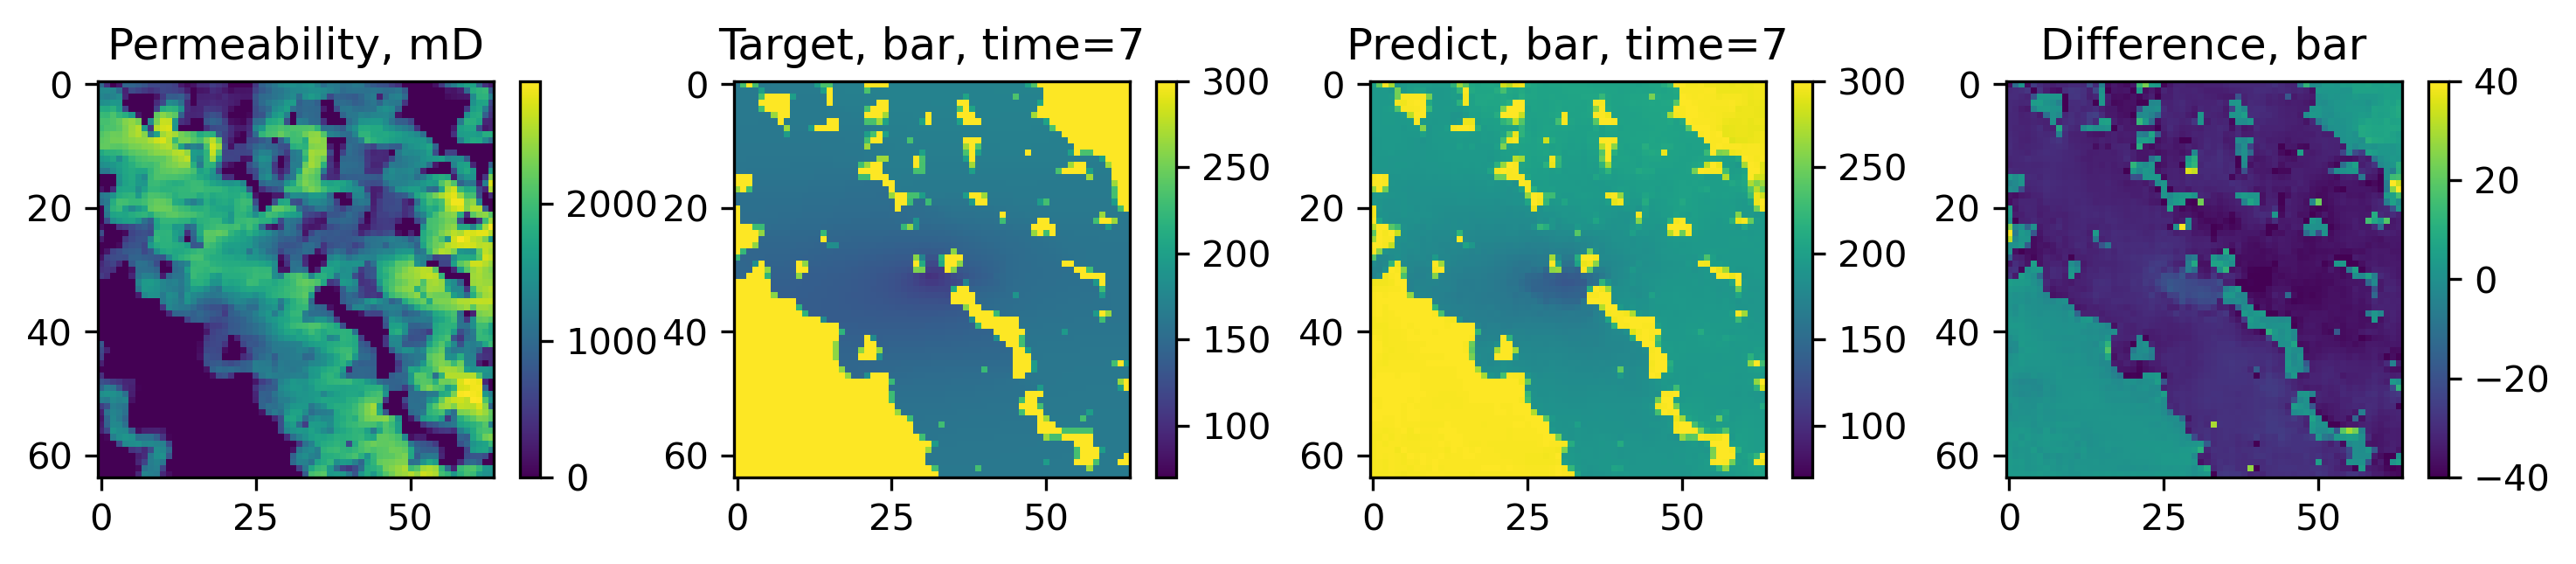

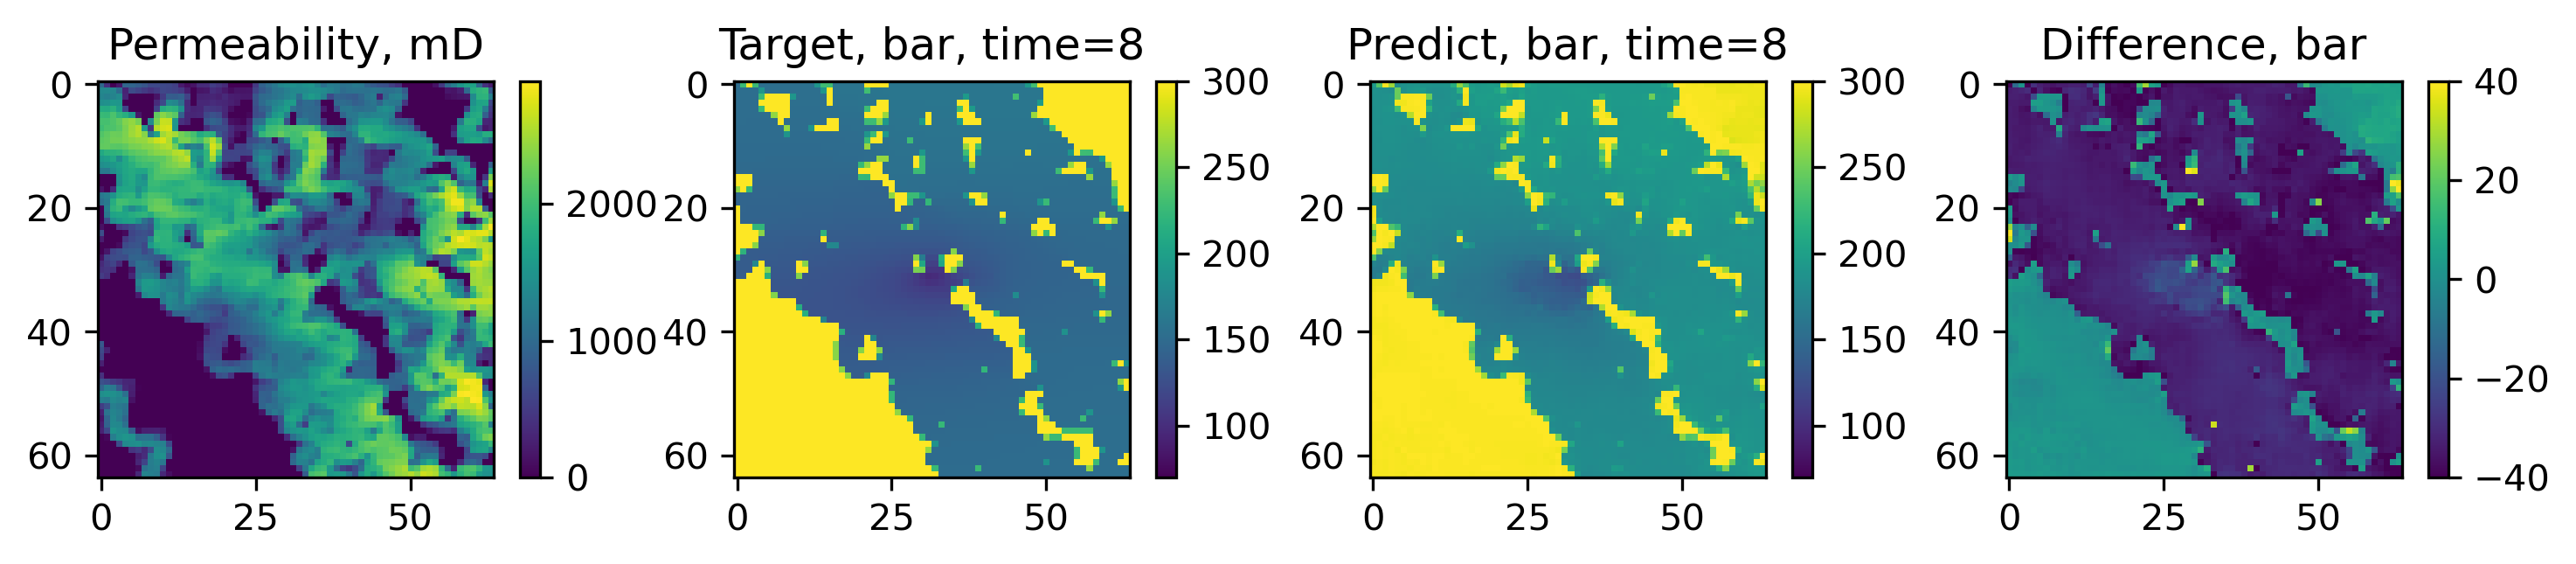

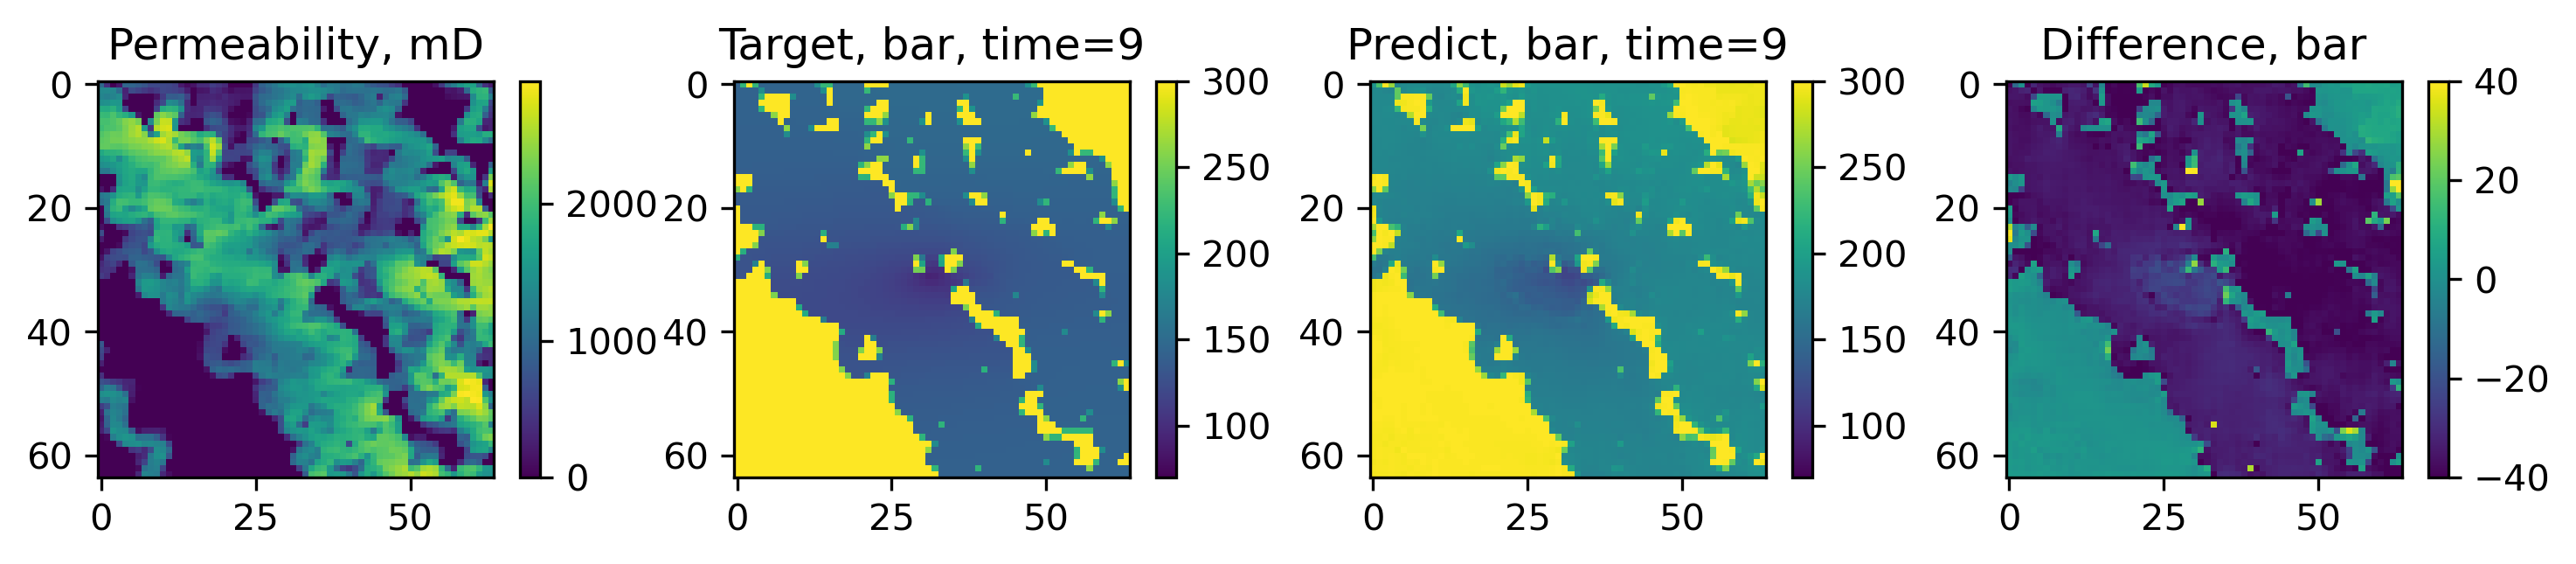

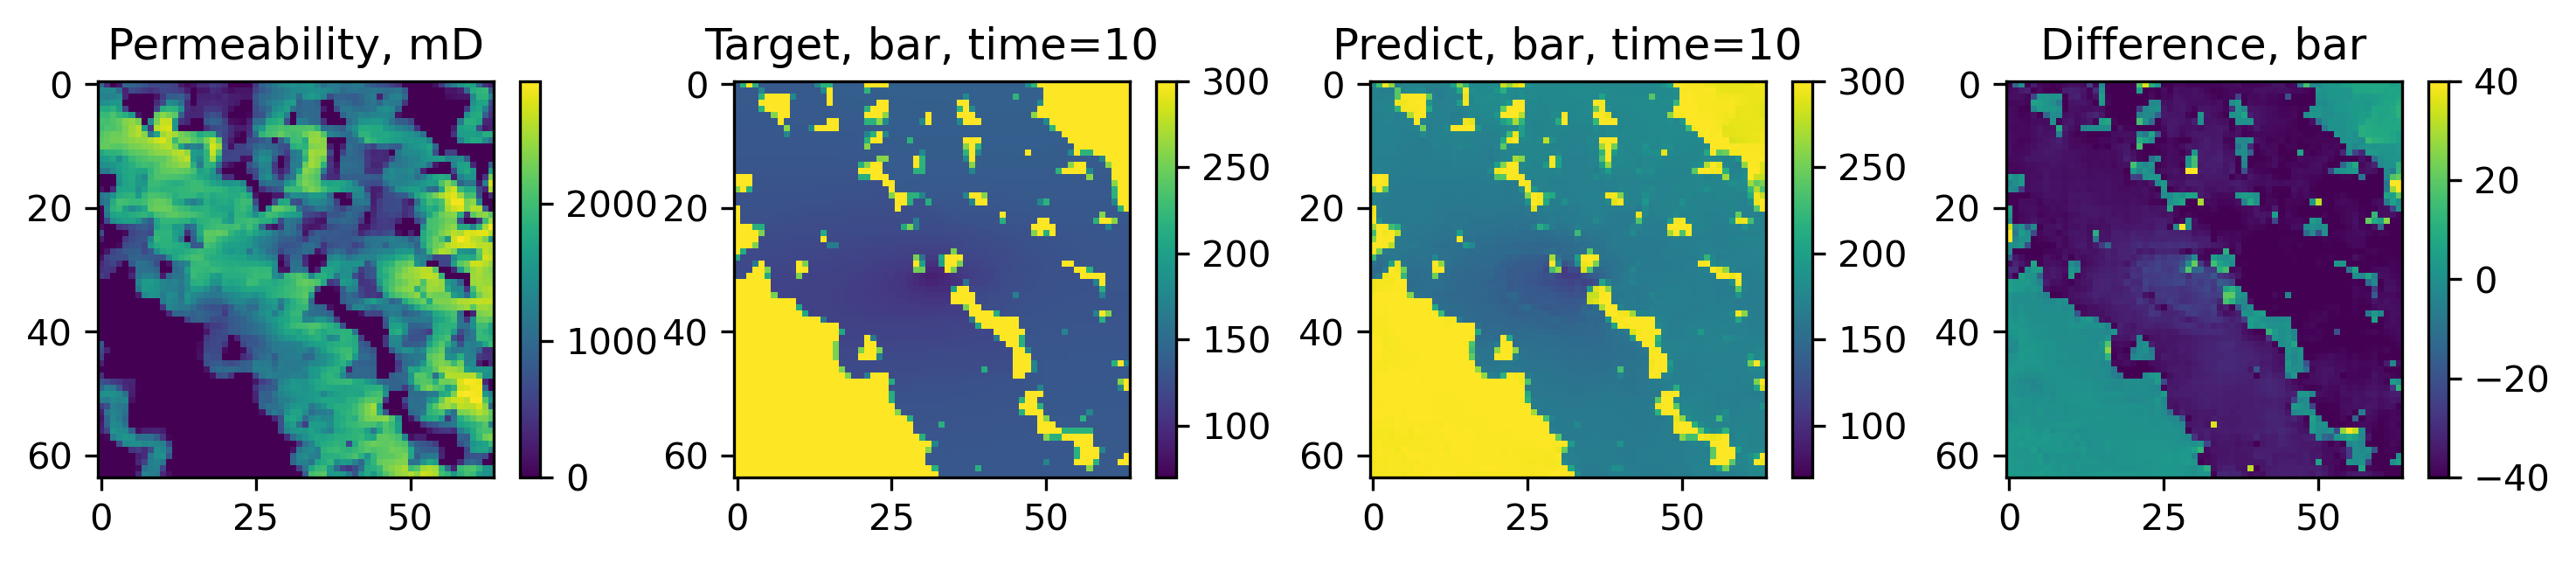

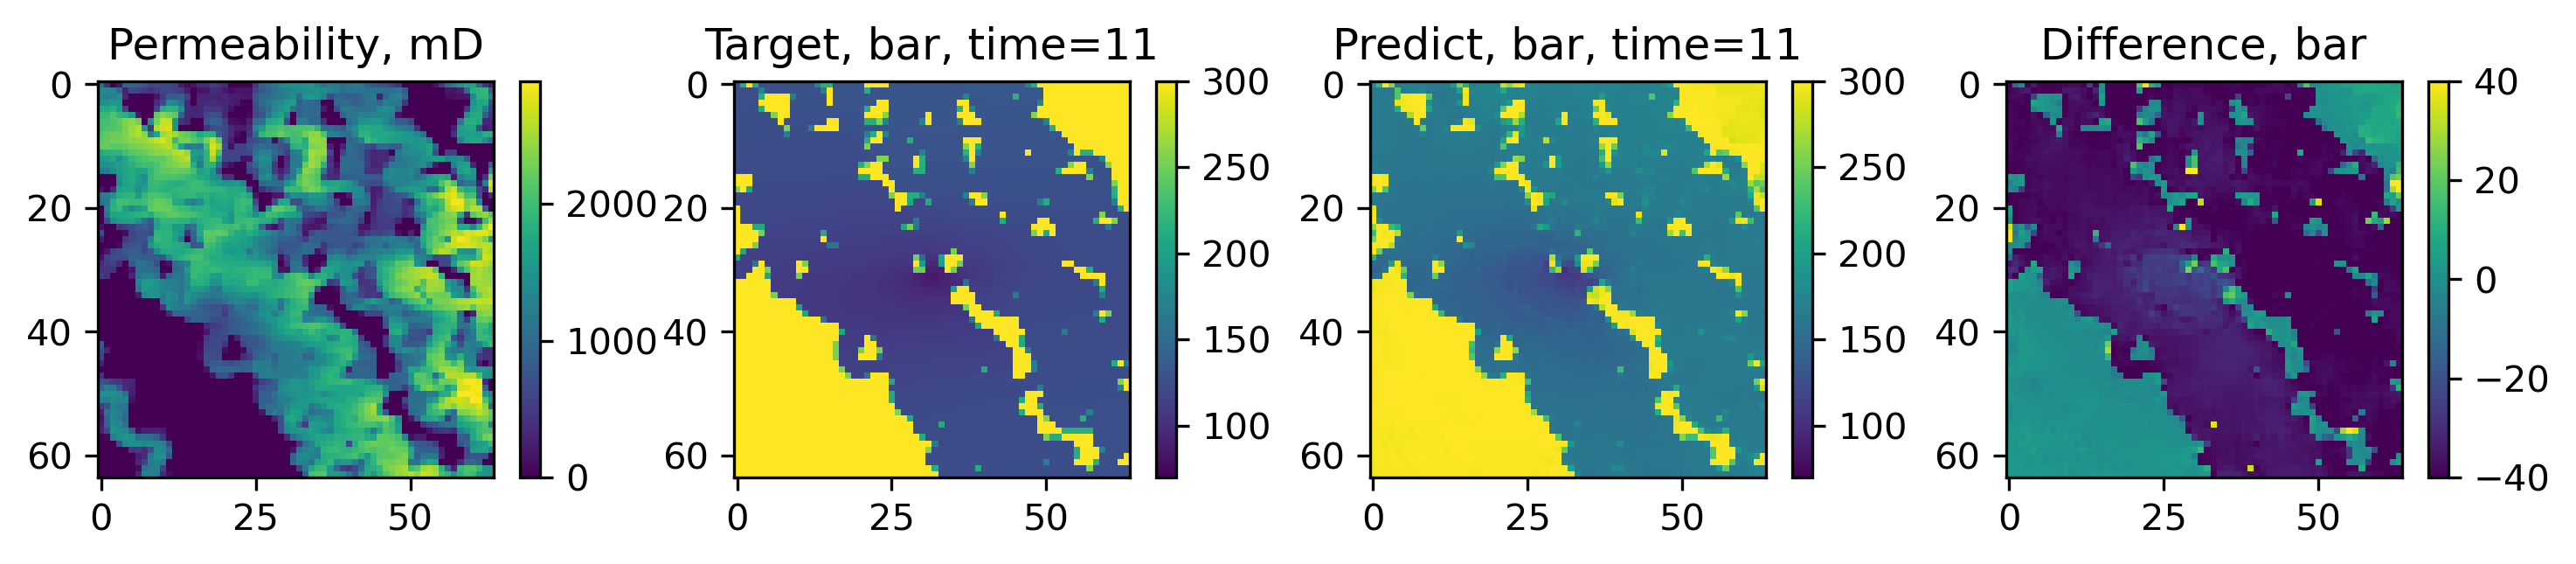

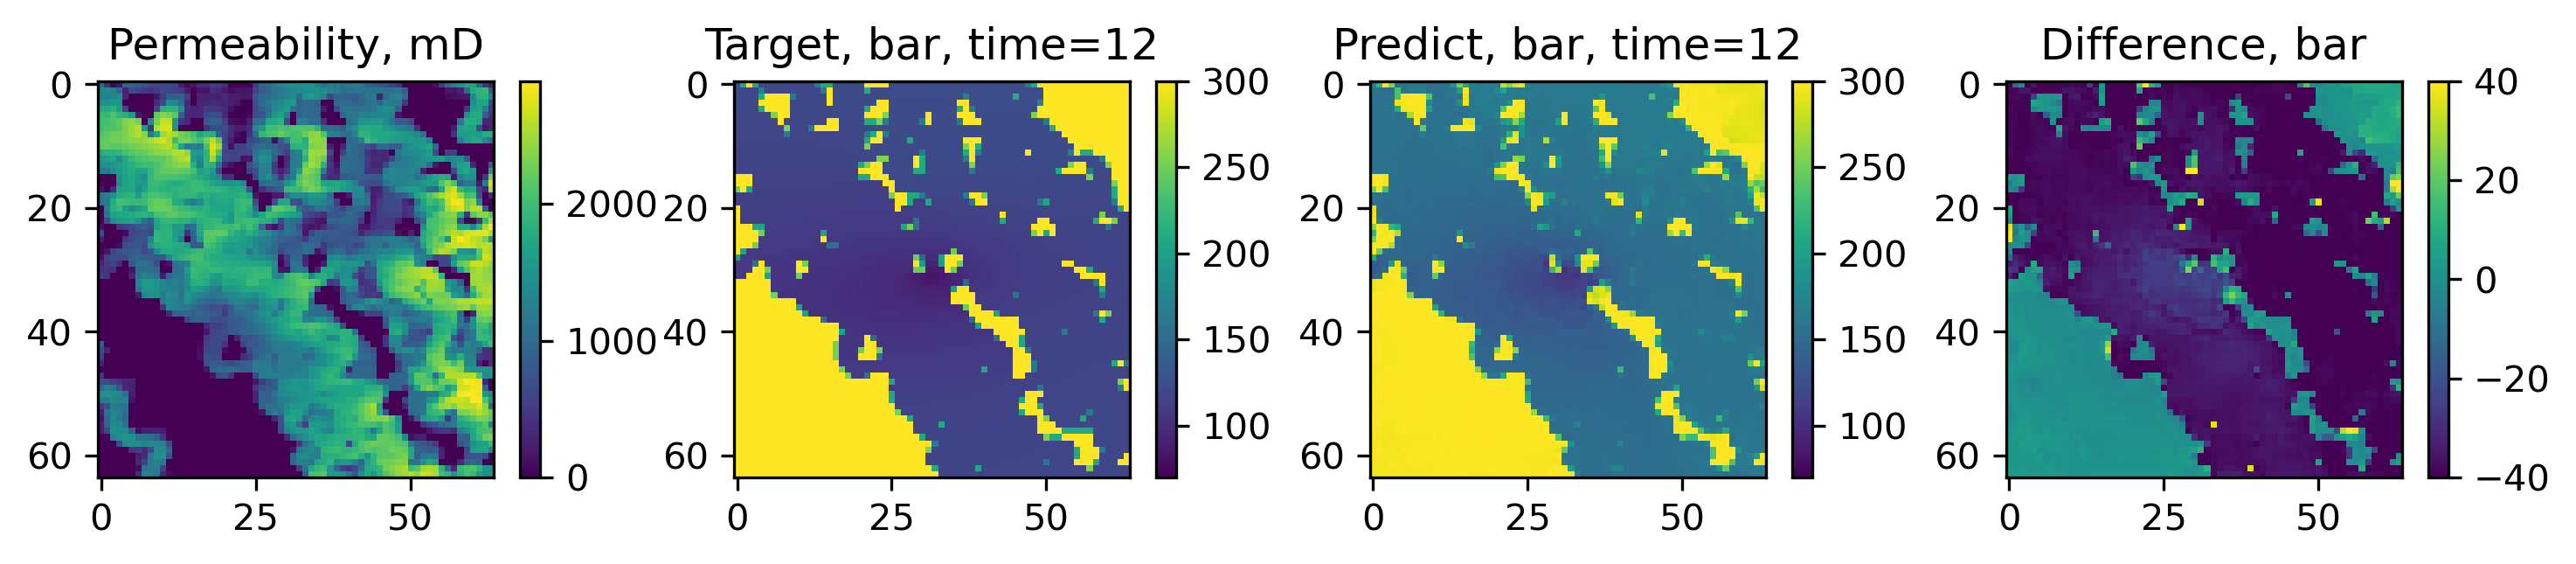

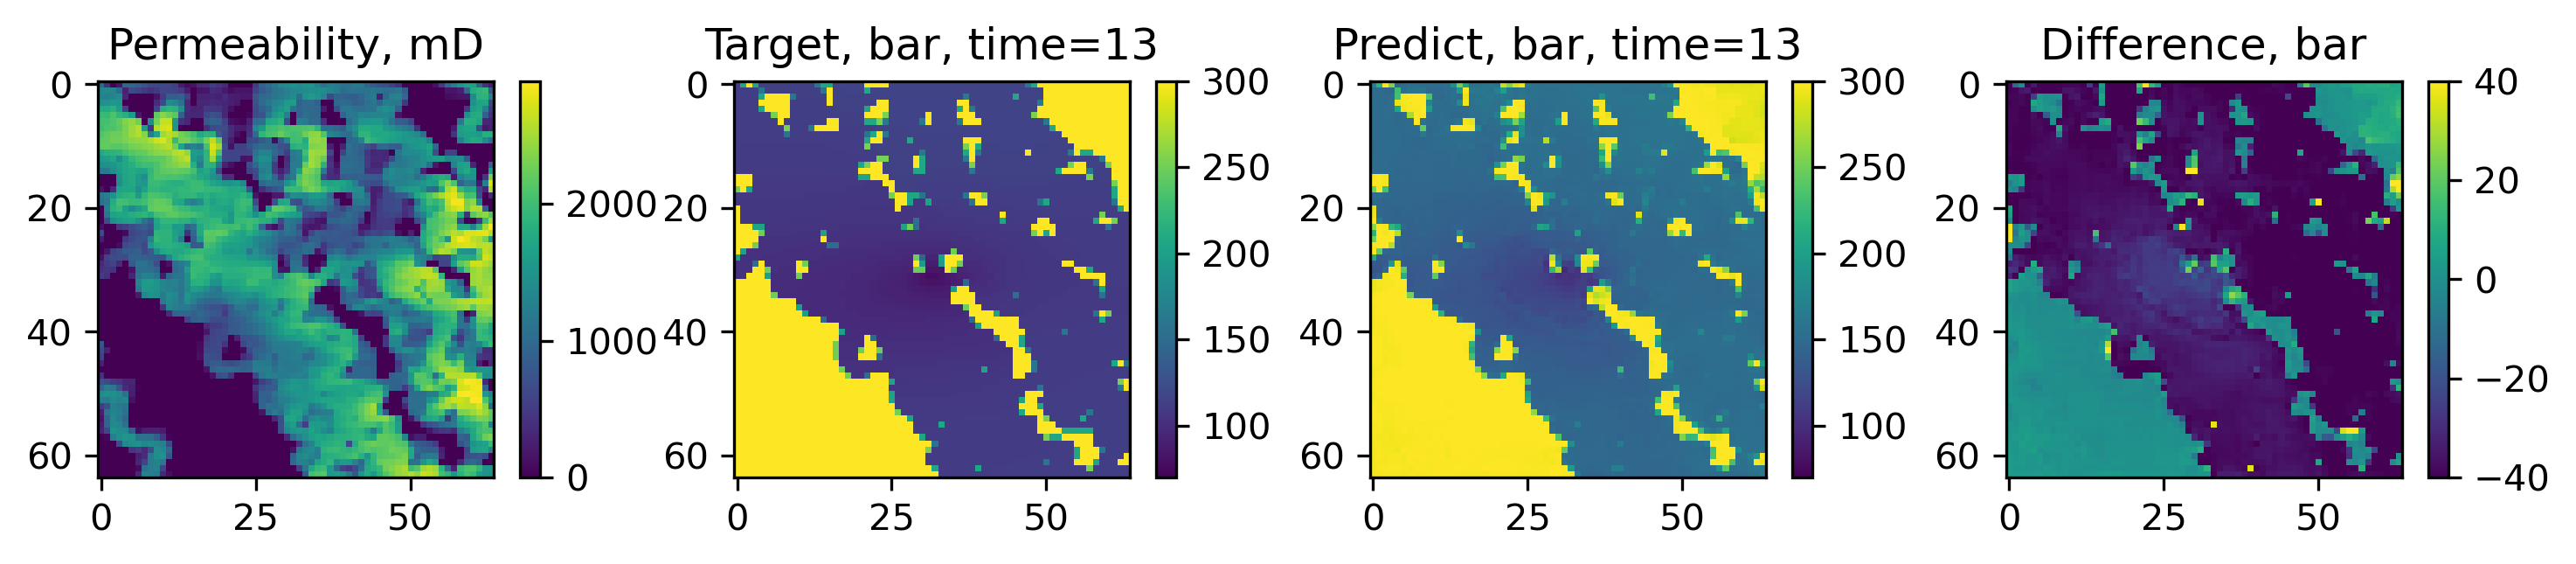

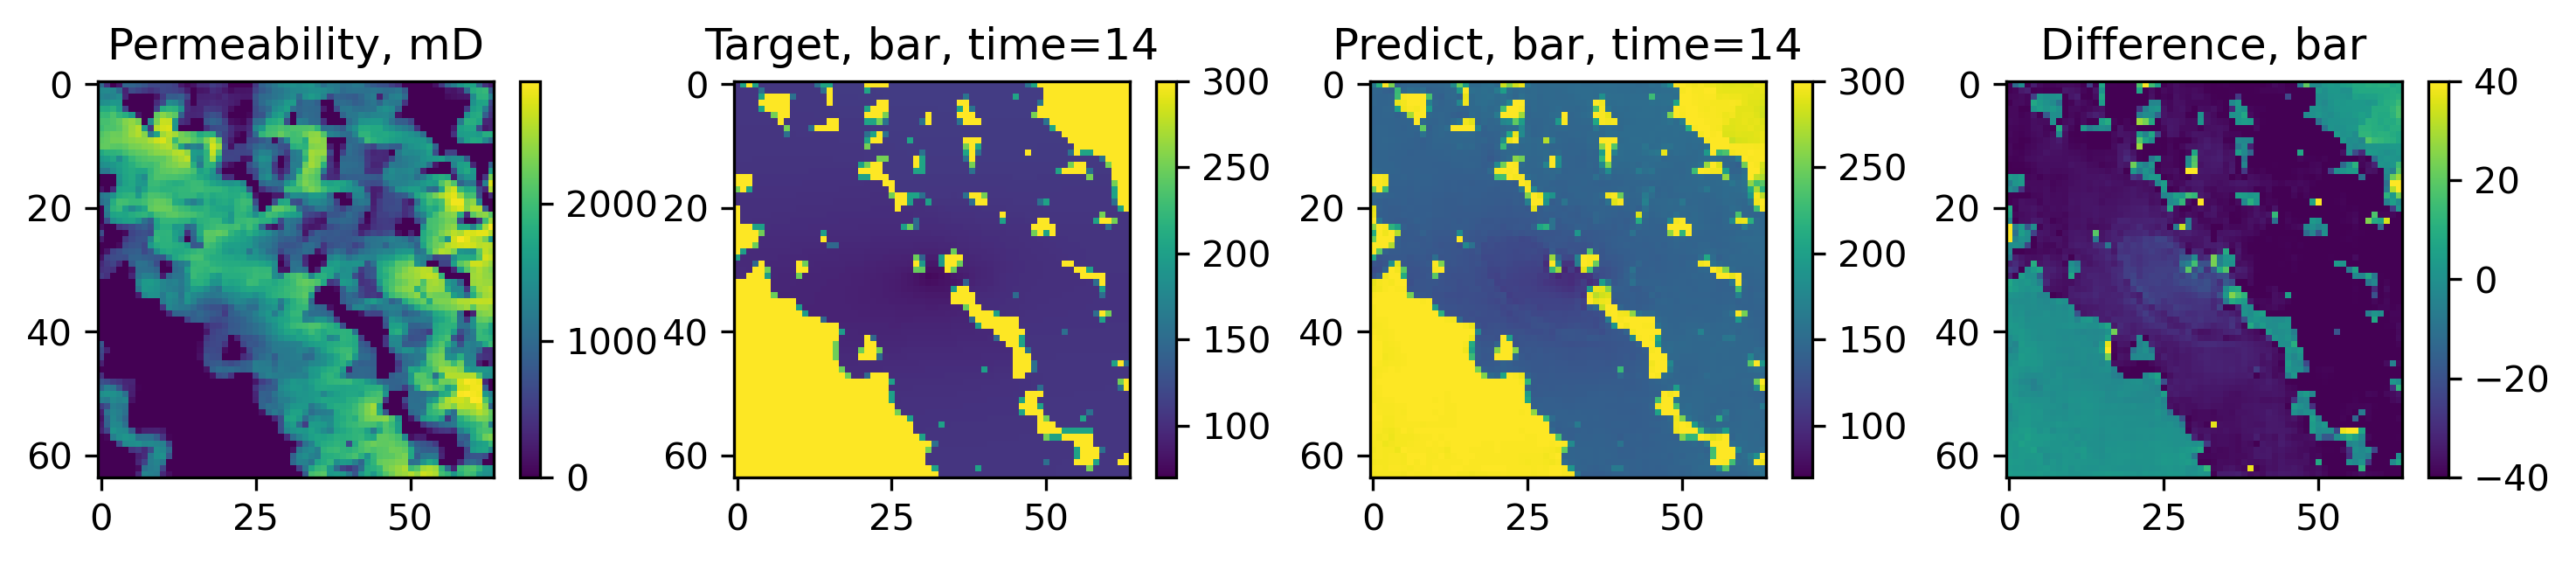

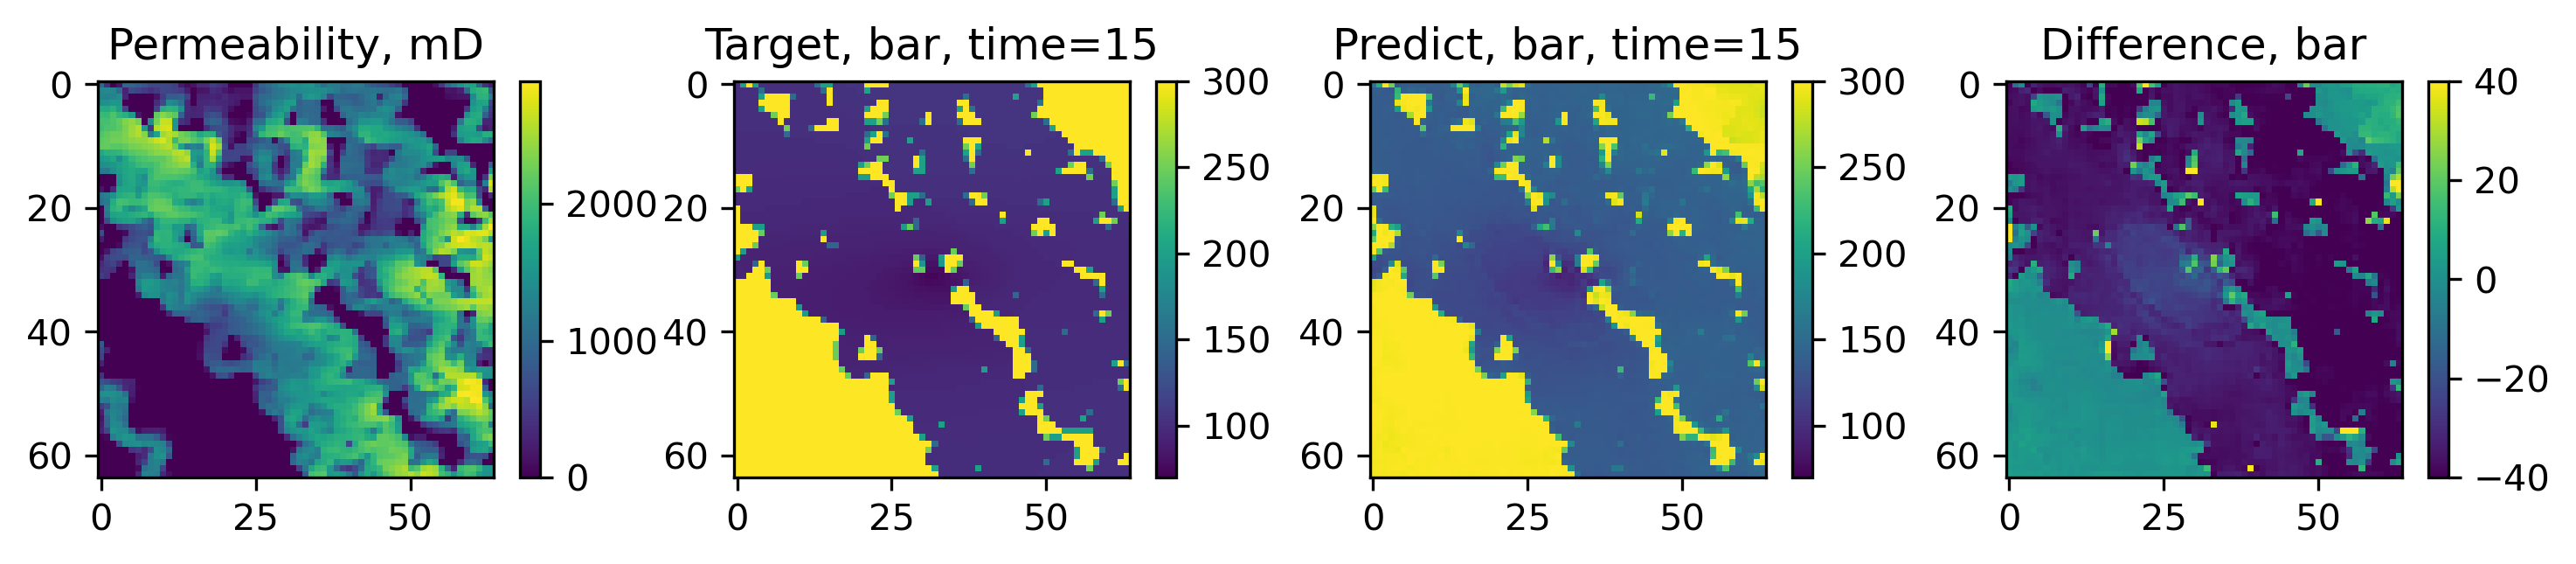

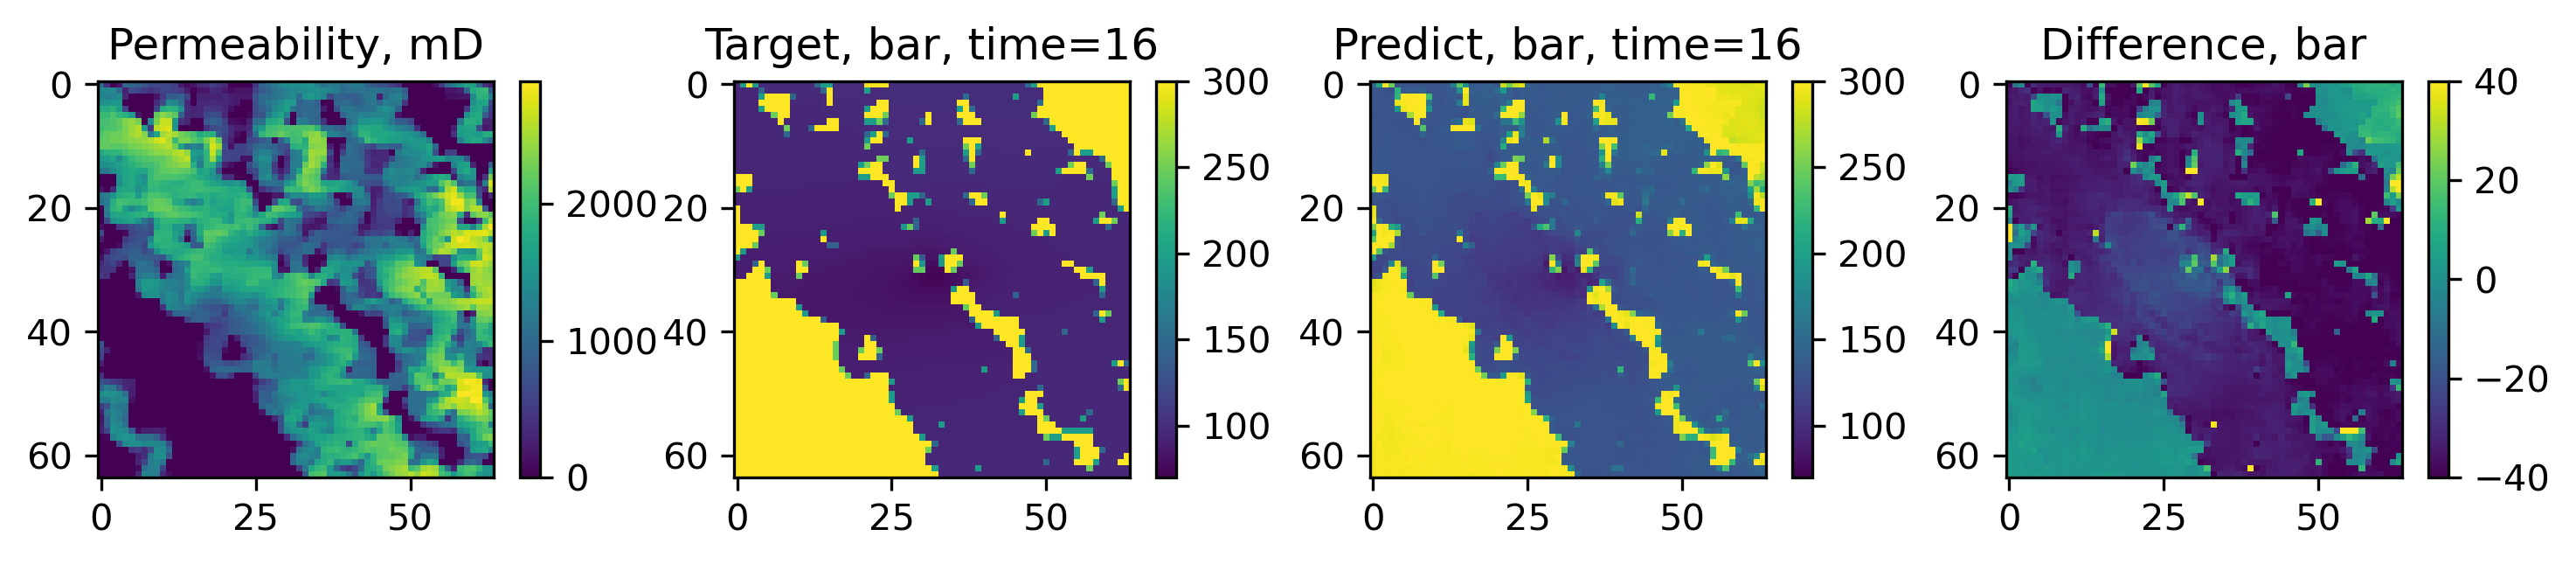

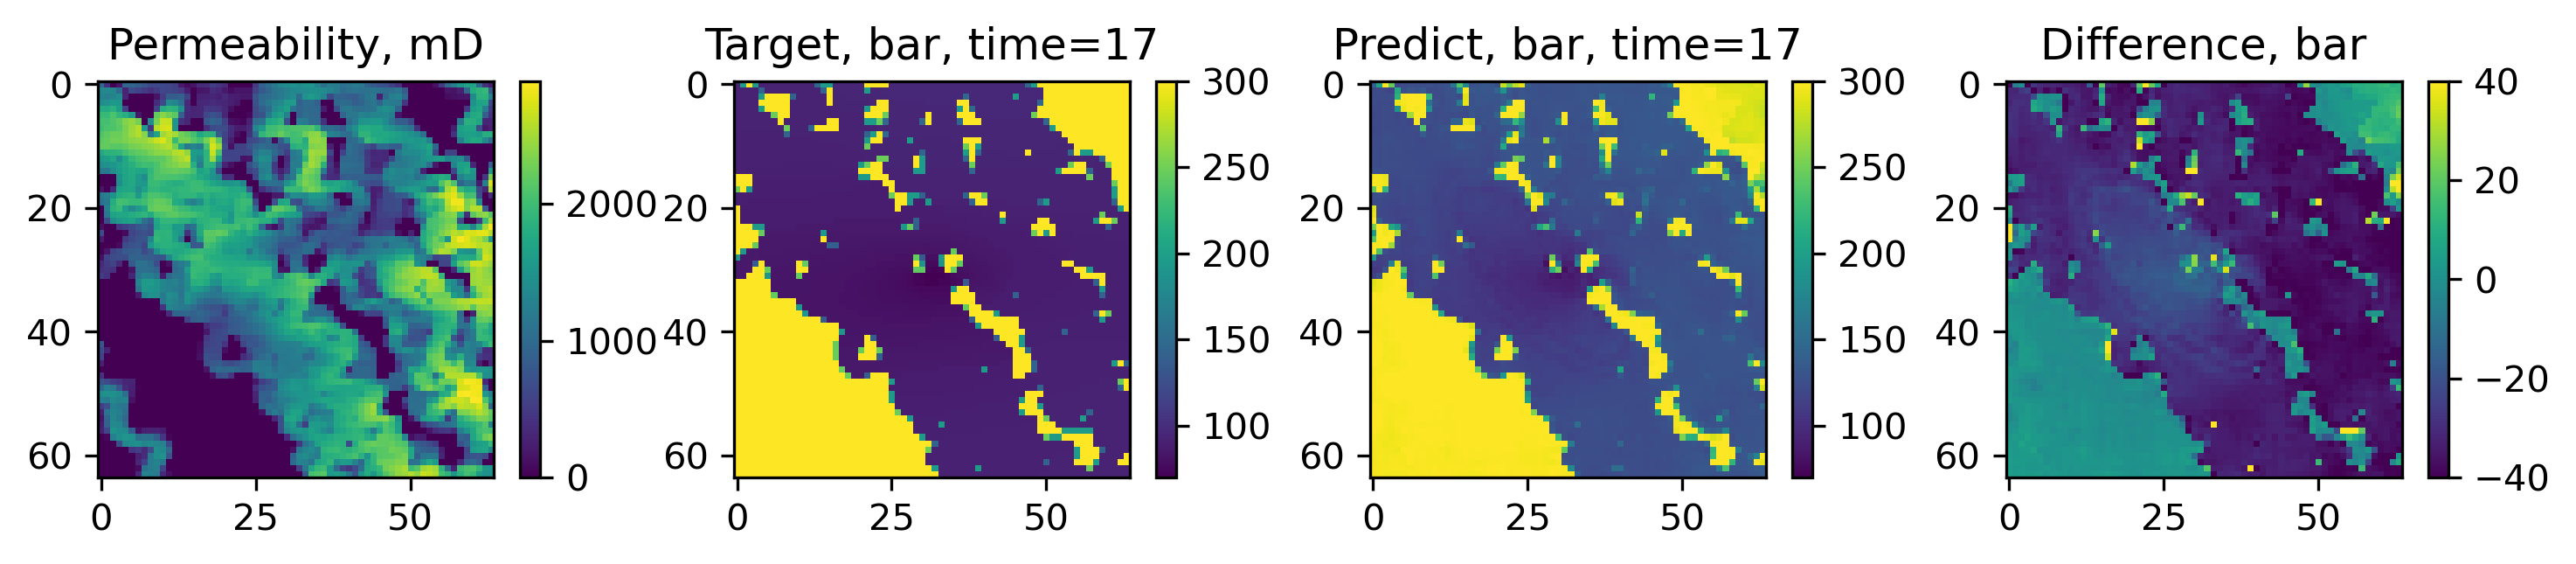

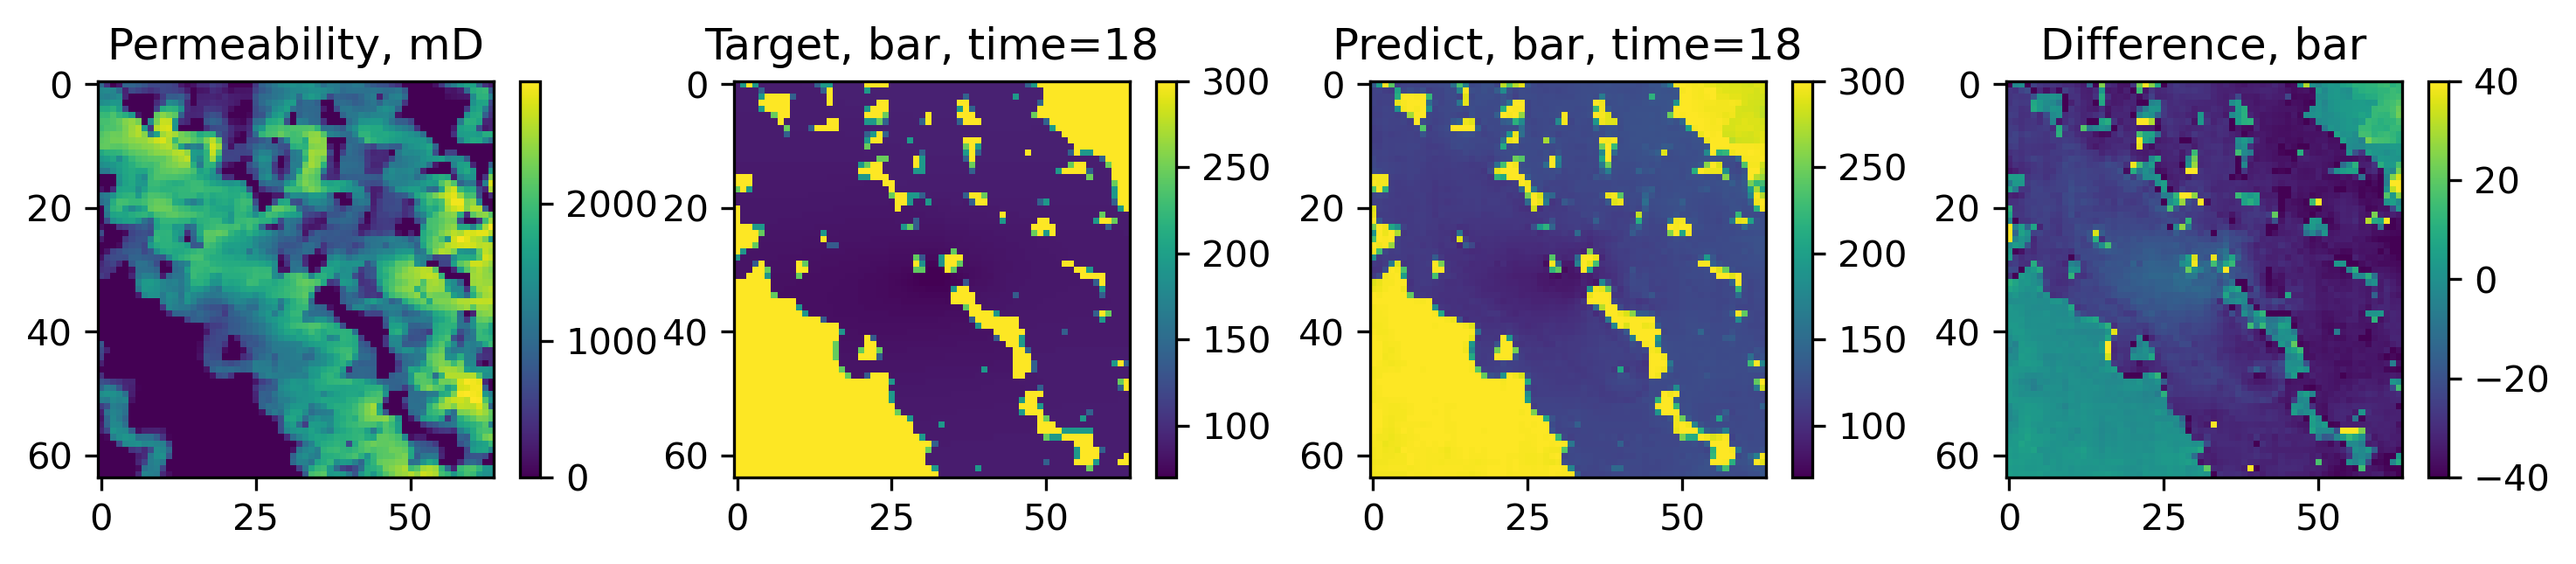

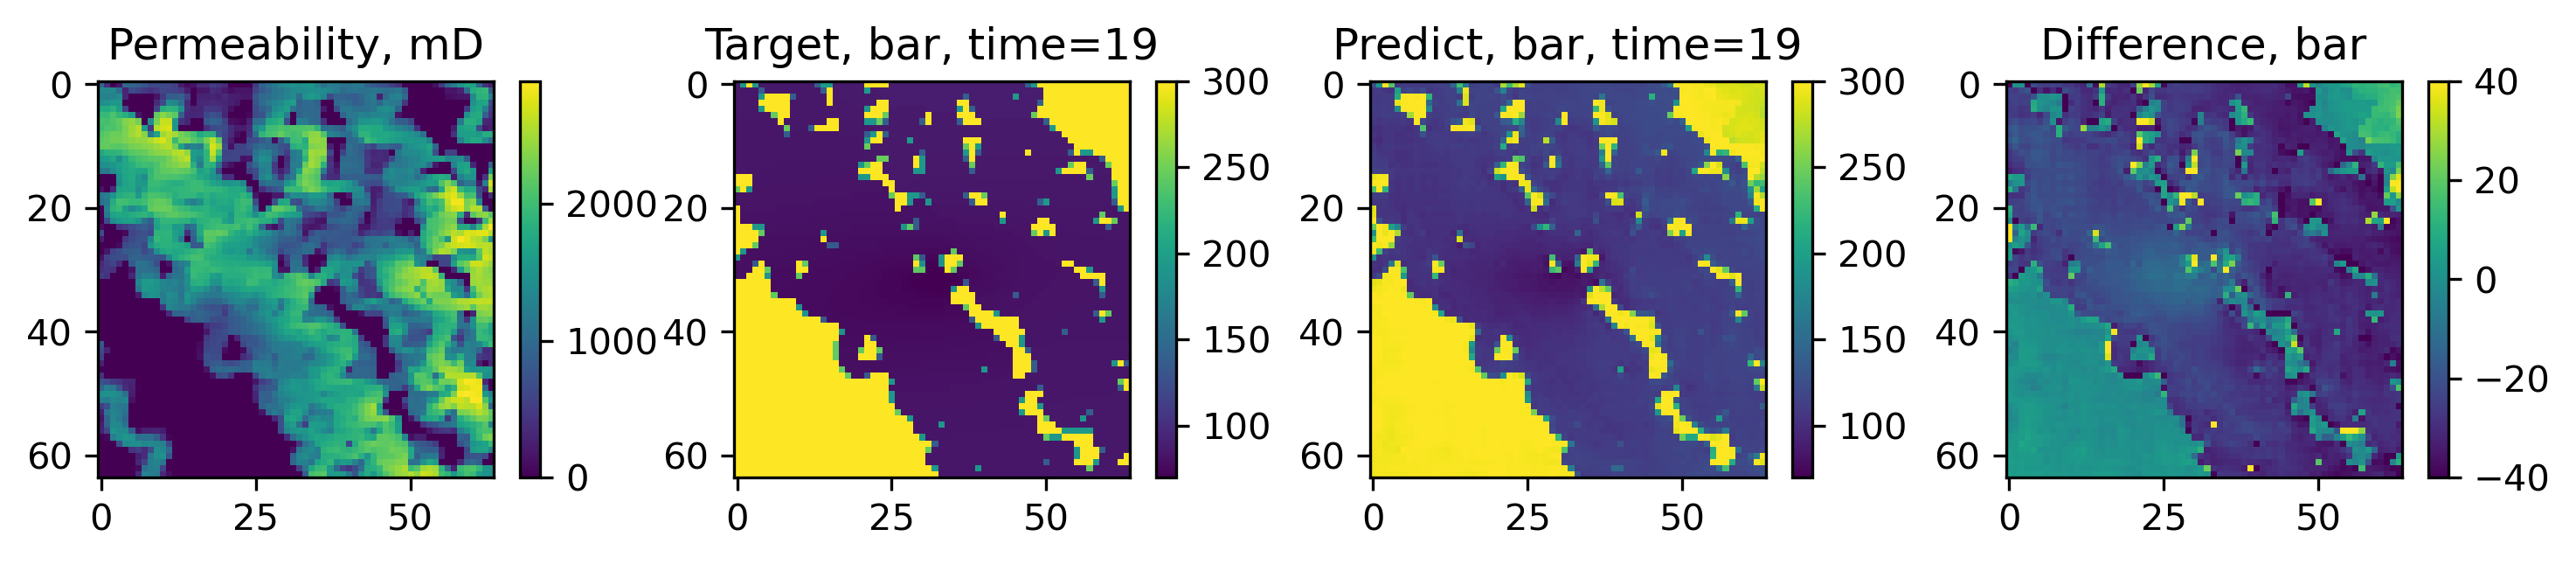

In [33]:
idxs = range(1,21)
for i in range(len(idxs)):
    fig, axes = plt.subplots(1, 4, figsize=(12,2), dpi=300)
    target, pred, diff, k = one_prediction_with_x(idxs[i])
    true = axes[0].imshow(k)
    axes[0].set_title(f'Permeability, mD')
    fig.colorbar(true, ax=axes[0])
    true = axes[1].imshow(target, vmin = 70, vmax = 300)
    axes[1].set_title(f'Target, bar, time={i}')
    fig.colorbar(true, ax=axes[1])
    true = axes[2].imshow(pred, vmin = 70, vmax = 300)
    axes[2].set_title(f'Predict, bar, time={i}')
    fig.colorbar(true, ax=axes[2])
    true = axes[3].imshow(diff,vmin = -40, vmax = 40)
#         true = axes[3].imshow(diff)
    axes[3].set_title(f'Difference, bar')
    fig.colorbar(true, ax=axes[3])
    plt.show()

In [34]:
test_loss = []

for i in tqdm(range(len(test_dataset))):
    sample, target = test_dataset[i]
    sample, target = sample.to(device, torch.float), target.to(device, torch.float) 
    pred = model(sample.unsqueeze(0))
    loss = loss_data(pred[0], target)
    test_loss.append(np.sqrt(loss.item()))

print(f'RMSE: {np.mean(test_loss)}')

100%|██████████████████████████████████████| 2751/2751 [00:12<00:00, 226.60it/s]

RMSE: 16.072415651807265
